In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns

sns.set_context("poster")

from matplotlib import rc
rc('text', usetex=True)


In [2]:
# Note msqrobresults from 20201006 are results with squeeze_variance= FALSE

In [3]:
fcs =  [round(i*0.04,2) for i in range(20)]


In [4]:

import os 
import pandas as pd
import numpy as np
# git 
os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")
from triqler_output_to_df import parse_triqler
from q_value import qvalues


# db
#from get_protein_specie_map_from_fasta import fasta_to_protein_specie_map
os.chdir("/home/ptruong/git/dia_sum/database")
#protein_specie_map = fasta_to_protein_specie_map("2021-04-27-decoys-reviewed-contam-UP000005640-UP000002311-UP000000625.fas")
#protein_specie_map = protein_specie_map.set_index("protein").T.to_dict()
# MSFragger 
#os.chdir("/hdd_14T/data/PXD002952/res_20210530_DIAUmpire/MSFragger")
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")


In [5]:
# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

In [6]:
df = pd.read_csv("report.tsv", sep = "\t")
triq = pd.read_csv("triqler_input_diann_searchScore_Qvalue.csv", sep = "\t")                      



In [7]:
triq.run.unique()

array(['002-Pedro', '003-Pedro', '004-Pedro', '005-Pedro', '006-Pedro',
       '007-Pedro'], dtype=object)

In [8]:

def compute_triqler_top3_submodule(run):
    triq_run = triq[triq.run == run]   
    triq_run.searchScore = np.e**(-1 * triq_run.searchScore) #re-convert searchScore, because our triqler_input has -np.log(-Q.Value) from diann result.tsv as searchScore
    triq_run = triq_run[triq_run["searchScore"] < 0.01]
    
    def triqler_top3(triq_run):
        res = triq_run.groupby("proteins")["intensity"].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan).reset_index()
        return res
    
    def triqler_printout_unique_peptides_proteins(run):
        #triq_run = triq[triq.run == run]
        #print(len(triq_run[triq_run["searchScore"] < 0.01].peptide.unique()))
        condition = triq_run.condition.unique()
        print(f"run : {run} - condition : {condition}")
        print(f"Unique peptides detected: {len(triq_run.peptide.unique())}")
        print(f"Unique proteins detected: {len(triq_run.proteins.unique())}")
        print()
    
    triqler_printout_unique_peptides_proteins((run))
    
    res = triqler_top3(triq_run)
    #def remove_decoy_tag_protein(protein):
    #    if protein.split("_")[0] == "DECOY":
    #        return protein.split("_")[1]
    #    else: return protein.split("_")[0]
    
    #res["proteins_nonTagged"] = res.proteins.map(remove_decoy_tag_protein)
    #res["specie"] = res.proteins_nonTagged.map(protein_specie_map)
    experiment_id = triq_run.run.unique()[0]
    sample_id = triq_run.condition.unique()[0]
    #res["ProteinName"] = res["proteins"]
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    #res = res.set_index(["specie", "ProteinName"])
    #res = res.drop(["proteins", "proteins_nonTagged"], axis = 1)
    df = pd.DataFrame(res.values)
    
    specie_map = lambda x: x.split("_")[-1]
    protein_map = lambda x: x.split("_")[-2]
    res["specie"] = res.proteins.map(specie_map)
    res["ProteinName"] = res.proteins
    res = res.drop(["proteins"], axis = 1)
    res = res.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(res.values, columns = midx, index = res.index)
    return df
#df = compute_triqler_top3_submodule(run)

dfs = []
for run in triq.run.unique():
    dfs.append(compute_triqler_top3_submodule(run))
     
df = pd.concat(dfs, axis = 1)
df # Check why we have more species than in the fasta??? Is this because of how we build the spectral library?
df = df[df.index.get_level_values("specie").isin(["HUMAN", "ECOLI", "YEAST"])]

#df[df.index.get_level_values("specie").isin(["HUMAN"])]
#df[df.index.get_level_values("specie").isin(["ECOLI"])]
#df[df.index.get_level_values("specie").isin(["YEAST"])]

df = pd.concat(dfs, axis = 1)



A = df[df.iloc[:, df.columns.get_level_values("sample_id") == 1].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == 1]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == 2].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == 2]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res



import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()


/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 002-Pedro - condition : [1]
Unique peptides detected: 21036
Unique proteins detected: 3377



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 003-Pedro - condition : [2]
Unique peptides detected: 21243
Unique proteins detected: 3358



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 004-Pedro - condition : [1]
Unique peptides detected: 20783
Unique proteins detected: 3350



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 005-Pedro - condition : [2]
Unique peptides detected: 21325
Unique proteins detected: 3381



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 006-Pedro - condition : [1]
Unique peptides detected: 21040
Unique proteins detected: 3368



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 007-Pedro - condition : [2]
Unique peptides detected: 21248
Unique proteins detected: 3356



In [9]:

import time
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        # Added specie mapping... need to check the problem with BOVIN, SCVLA proteins???
        #print(df_triq)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        df_triq["protein"] = df_triq["protein"] + "_" + df_triq["specie"]
        df_triq = df_triq[df_triq["specie"].isin(["HUMAN", "ECOLI", "YEAST"])]
        df_triq = df_triq[df_triq.q_value < q_val]
        #df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df


#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res
fcs =  [round(i*0.04,2) for i in range(20)]

res = get_DE_for_fcs( fcs = fcs)


In [10]:

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")

#msqrob = pd.read_csv("msqrobsum_result_20211006.csv", sep = "\t")

#msqrob = pd.read_csv("msqrobsum_result_20211105_filtered_before.csv", sep = "\t")
msqrob = pd.read_csv("msqrob2_results.tsv", sep = ",", index_col = 0)
msqrob["proteins"] = msqrob.index


#msqrob = pd.read_csv("msqrob_result_20220110_filtered_before.csv", sep = "\t")

msqrob.dropna(subset=["proteins"], inplace=True)
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        #n = (msqrob_fc["qvalue"] <= q).sum()
        n = (msqrob_fc["adjPval"] <= q).sum()
        
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res


In [11]:
msqrob

,logFC,se,df,t,pval,adjPval,proteins,specie
A0A1W2PP97_HUMAN,-0.106943,0.050651,4.891521,-2.111392,0.089697,0.122747,A0A1W2PP97_HUMAN,HUMAN
A0FGR8_HUMAN,-0.125361,0.051492,5.026937,-2.434564,0.058781,0.085762,A0FGR8_HUMAN,HUMAN
A1L0T0_HUMAN,-0.085469,0.046389,5.986146,-1.842456,0.115100,0.150771,A1L0T0_HUMAN,HUMAN
A1Z1Q3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,A1Z1Q3_HUMAN,HUMAN
A5YKK6_HUMAN,-0.080354,0.067864,5.711142,-1.184051,0.283320,0.331019,A5YKK6_HUMAN,HUMAN
...,...,...,...,...,...,...,...,...
Q9Y697_HUMAN,-0.336987,0.145477,5.652680,-2.316427,0.062374,0.090267,Q9Y697_HUMAN,HUMAN
Q9Y6A9_HUMAN,-0.223731,0.073752,5.841763,-3.033541,0.023775,0.040896,Q9Y6A9_HUMAN,HUMAN
Q9Y6C9_HUMAN,-0.240814,0.060540,5.986146,-3.977799,0.007336,0.015208,Q9Y6C9_HUMAN,HUMAN
Q9Y6E2_HUMAN,-0.160771,0.058061,5.959289,-2.768981,0.032698,0.052626,Q9Y6E2_HUMAN,HUMAN


In [12]:
#check_type_protein = lambda x: type(x)
#msqrob["type"] = msqrob.proteins.map(check_type_protein)

In [13]:
#msqrob[msqrob["type"] == float]


In [14]:
#msqrob = msqrob[msqrob.qvalue < 0.01]

In [15]:
def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")

#ms = pd.read_csv("msstat_output_filtered.csv")
#ms = pd.read_csv("msstat_output_tresholded_20211104.csv")
ms = pd.read_csv("msstat_output_tresholded_20222121.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

# Same code but for osw

In [16]:

import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")



# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False
    
def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id.unique()[0]
    experiment_id = df.experiment_id.unique()[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    print(f"Proteins {len(df.ProteinName.unique())}")
    print("")
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df



# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-10:] == "dscore.csv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)

df["decoy"] = df.index.get_level_values("ProteinName").map(decoy_mapper) 
df.decoy.sum()

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]





import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final_osw = pd.concat([A, B, p_vals], axis = 1)
df_final_osw["log2(A,B)"] = df_final_osw["1"] - df_final_osw["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML_with_dscore.csv
20494 significantly identified peptides at 0.01 FDR-treshold.
Proteins 2818

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML_with_dscore.csv
22787 significantly identified peptides at 0.01 FDR-treshold.
Proteins 2918

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML_with_dscore.csv
20747 significantly identified peptides at 0.01 FDR-treshold.
Proteins 2836

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML_with_dscore.csv
22792 significantly identified peptides at 0.01 FDR-treshold.
Proteins 2909

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML_with_dscore.csv
21445 significantly identified peptides at 0.01 FDR-treshold.
Proteins 2857

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.

In [17]:

import time
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq = df_triq[df_triq.q_value < q_val]
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res

res_osw = get_DE_for_fcs( fcs = fcs)


In [20]:
def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")

#ms_osw = pd.read_csv("msstats_output_filtered.csv")
#ms_osw = pd.read_csv("msstat_output_tresholded_20211104.csv")
ms_osw = pd.read_csv("msstat_output_tresholded_20222121.csv")
ms_osw["specie"] = ms_osw.Protein.map(specie_mapper)
ms_osw.replace([np.inf, -np.inf], np.nan, inplace=True)
ms_osw[ms_osw.specie == "YEAS8"]



,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,specie


In [21]:
ms_osw

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,specie
0,A0A1W2PP97_HUMAN,T2-T1,-0.087293,0.015324,-5.696373,2.0,0.029463,0.054867,NaN,0.000000,0.000000,HUMAN
1,A0FGR8_HUMAN,T2-T1,-0.181204,0.014791,-12.251186,2.0,0.006597,0.018945,NaN,0.125000,0.125000,HUMAN
2,A1L0T0_HUMAN,T2-T1,-0.110880,0.048199,-2.300481,2.0,0.148099,0.184221,NaN,0.055556,0.055556,HUMAN
3,A5YKK6_HUMAN,T2-T1,0.001598,0.053660,0.029785,2.0,0.978944,0.980439,NaN,0.000000,0.000000,HUMAN
4,A5Z2X5_YEAST,T2-T1,-0.603577,0.022393,-26.954232,2.0,0.001374,0.008401,NaN,0.000000,0.000000,YEAST
...,...,...,...,...,...,...,...,...,...,...,...,...
3204,Q9Y697_HUMAN,T2-T1,-0.113035,0.059955,-1.885350,2.0,0.200041,0.236814,NaN,0.083333,0.083333,HUMAN
3205,Q9Y6A9_HUMAN,T2-T1,-0.098278,0.045955,-2.138560,2.0,0.165887,0.201821,NaN,0.000000,0.000000,HUMAN
3206,Q9Y6C9_HUMAN,T2-T1,-0.129839,0.032507,-3.994241,2.0,0.057342,0.088146,NaN,0.000000,0.000000,HUMAN
3207,Q9Y6E2_HUMAN,T2-T1,-0.185946,0.078870,-2.357622,2.0,0.142449,0.178457,NaN,0.000000,0.000000,HUMAN


In [22]:
#os.chdir("/home/ptruong/git/MSqRobSum/inst/extdata")
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msrobsum_results_20211006")
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")

#msqrob_osw = pd.read_csv("msqrobsum_result_20211006.csv", sep = "\t")


msqrob_osw = pd.read_csv("msqrob2_results.tsv", sep = ",", index_col = 0)
msqrob_osw["proteins"] = msqrob_osw.index


#msqrob_osw = pd.read_csv("msqrobsum_result_20211105_filtered_before.csv", sep = "\t")


#msqrob_osw = pd.read_csv("msqrob_result_20220110_filtered_before.csv", sep = "\t")

#msqrob_osw.dropna(subset=["proteins"], inplace=True)

msqrob_osw["specie"] = msqrob_osw.proteins.map(specie_mapper)


def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        #n = (msqrob_fc["qvalue"] <= q).sum()
        n = (msqrob_fc["adjPval"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

#msqrob_pq_data(msqrob, fc = 0.2)

In [23]:
msqrob_osw

,logFC,se,df,t,pval,adjPval,proteins,specie
A0A1W2PP97_HUMAN,-0.188669,0.097686,7.297206,-1.931391,0.093035,0.177858,A0A1W2PP97_HUMAN,HUMAN
A0FGR8_HUMAN,-0.036023,0.141729,7.860442,-0.254171,0.805886,0.860133,A0FGR8_HUMAN,HUMAN
A1L0T0_HUMAN,0.207005,0.136089,6.860442,1.521093,0.172905,0.278531,A1L0T0_HUMAN,HUMAN
A5YKK6_HUMAN,-0.170219,0.087893,7.860442,-1.936652,0.089450,0.172483,A5YKK6_HUMAN,HUMAN
A5Z2X5_YEAST,-0.884194,0.118928,6.114766,-7.434681,0.000279,0.000856,A5Z2X5_YEAST,YEAST
...,...,...,...,...,...,...,...,...
Q9Y697_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,Q9Y697_HUMAN,HUMAN
Q9Y6A9_HUMAN,-0.093344,0.096476,6.939467,-0.967537,0.365778,0.482585,Q9Y6A9_HUMAN,HUMAN
Q9Y6C9_HUMAN,-0.227498,0.104420,6.802830,-2.178688,0.066881,0.136892,Q9Y6C9_HUMAN,HUMAN
Q9Y6E2_HUMAN,0.115703,0.122916,7.857477,0.941314,0.374578,0.490137,Q9Y6E2_HUMAN,HUMAN


In [24]:
#msqrob_osw = msqrob_osw[msqrob_osw.qvalue < 0.01]

In [25]:
 # TEMPTEMP
    
#(msqrob_fc["qvalue"] <= 0.01).sum()

In [26]:
#fc = 0.4
#msqrob = msqrob_osw
#msqrob_gt = msqrob[msqrob.logFC > fc]
#msqrob_lt = msqrob[msqrob.logFC < -fc]
#msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])

In [27]:
#msqrob_fc["new_q"] = qvalues(pd.DataFrame(msqrob_fc["pvalue"]), pcolname = "pvalue") # we give them slight better q than BH.

In [28]:
#msqrob_fc

In [29]:
#p_vals = stats.ttest_ind(A, B, axis = 1)[1]
#p_vals = pd.DataFrame(p_vals, columns = ["p"])
#p_vals["q"] = qvalues(p_vals)
#p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
#p_vals.sort_values("q",inplace =True)
#p_vals = p_vals.astype(float)


In [30]:
len(ms)

3209

In [31]:
ms.replace([np.inf, -np.inf], np.nan, inplace=True)

In [32]:
ms.dropna(subset=["log2FC"], inplace = True)

In [33]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAST"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAST"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAST"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAST"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
        #                              "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStat", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(4, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()

In [34]:

# diann
print("DIANN")
print(f"df_final: {len(df_final)}")
print(f"ms: {len(ms)}")
print(f"msqrob: {len(msqrob)}")
print(f"res: {len(res)}")
print()


#osw
print("OSW")
print(f"df_final_osw: {len(df_final_osw)}")
print(f"ms_osw: {len(ms_osw)}")
print(f"msqrob_osw: {len(msqrob_osw)}")
print(f"res_osw: {len(res_osw)}")

DIANN
df_final: 2632
ms: 3190
msqrob: 3285
res: 20

OSW
df_final_osw: 2029
ms_osw: 3209
msqrob_osw: 3035
res_osw: 20


## N-differentially expressed proteins
This is used to show number of differentially expresed proteins

In [35]:
row = 0
col = 0

def plot_pq(specie, linewidth, legend = True):
    triq = res[15] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final, fc_treshold = 0.4)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms, fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob, fc = 0.4)
        triq.sum(axis=1).plot(ax = axs, linewidth=linewidth)

    else:
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = 0.4)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = 0.4)
        triq[specie].plot(ax = axs, linewidth=linewidth)
    
    axs.plot(df.index, df.DE, linewidth=linewidth) # plot osw top3
    axs.plot(df_ms.index, df_ms.DE, linewidth=linewidth) # plot MSSTATS
    axs.plot(df_msqrob.index, df_msqrob.DE, linewidth=linewidth) # plot msqrob
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "msStats", "mSqRob"], fontsize = 16)
    axs.set_title(f"DIANN, {specie} (fc = {0.4})",  fontsize=18, fontweight='bold')
    axs.set_xlabel("q-value", fontsize=18, fontweight='bold')
    axs.set_ylabel("n - Differentially expressed.", fontsize=18, fontweight='bold')
    


In [36]:
row = 0
col = 0

def plot_pq_sns(specie, linewidth, legend = True, specie_string = None):
    triq = res[15] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final, fc_treshold = 0.0)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms, fc = 0.0)
        df_msqrob = msqrob_pq_data(msqrob, fc = 0.0)
        #triq.sum(axis=1).plot(ax = axs, linewidth=linewidth)
        sns.lineplot(data = triq.sum(axis=1).reset_index(), x = "index", y = 0, ax = axs)

    else:
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = 0.0)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = 0.0)
        df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = 0.0)
        #triq[specie].plot(ax = axs, linewidth=linewidth)
        sns.lineplot(data = triq.reset_index(), x = "index", y = specie, ax = axs)
    
    #axs.plot(df.index, df.DE, linewidth=linewidth) # plot osw top3
    sns.lineplot(data = df.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_ms.index, df_ms.DE, linewidth=linewidth) # plot MSSTATS
    sns.lineplot(data = df_ms.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_msqrob.index, df_msqrob.DE, linewidth=linewidth) # plot msqrob
    sns.lineplot(data = df_msqrob.reset_index(), x= "index", y = "DE", ax = axs)
    
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "MSstats", "MSqRob"], fontsize = 16)
    #axs.set_title(f"DIANN, {specie} (fc = {0.4})",  fontsize=18, fontweight='bold')
    #axs.set_xlabel("q-value", fontsize=18, fontweight='bold')
    axs.set_xlabel("q-value / FDR")
    #axs.set_ylabel("n - Differentially expressed.", fontsize=18, fontweight='bold')
    axs.set_ylabel(f"Differentially abundant ({specie_string})")
    

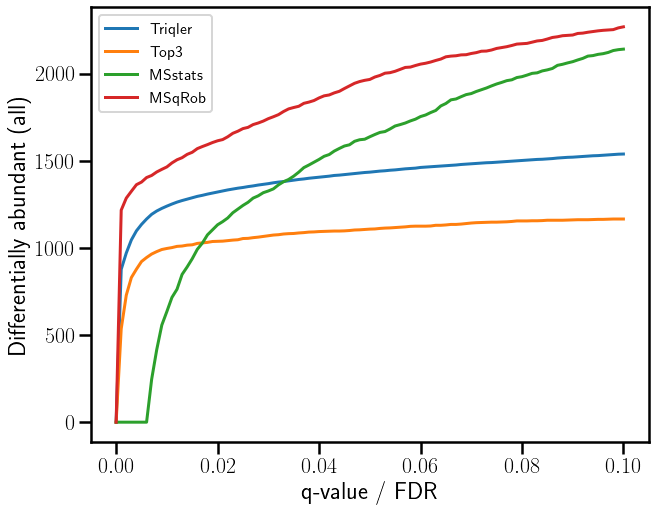

In [37]:
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

plot_pq_sns("all", linewidth = 5, legend = True, specie_string = "all")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_all.png', bbox_inches="tight")

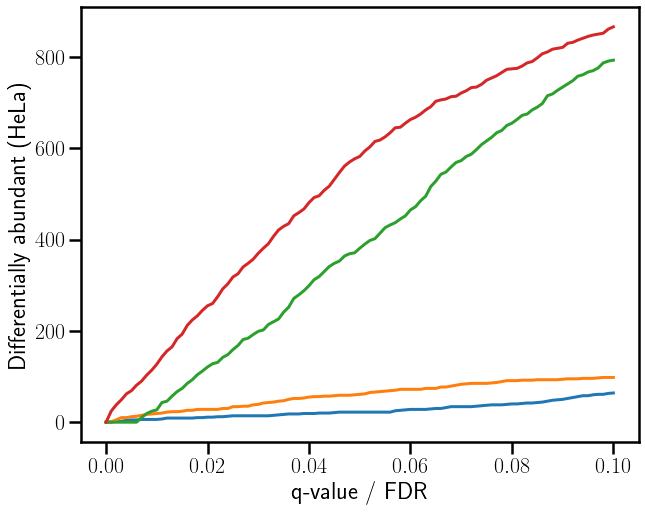

In [38]:

#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.6
plot_pq_sns("HUMAN", linewidth = 4, legend = False, specie_string = "HeLa")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_human.png', bbox_inches="tight")

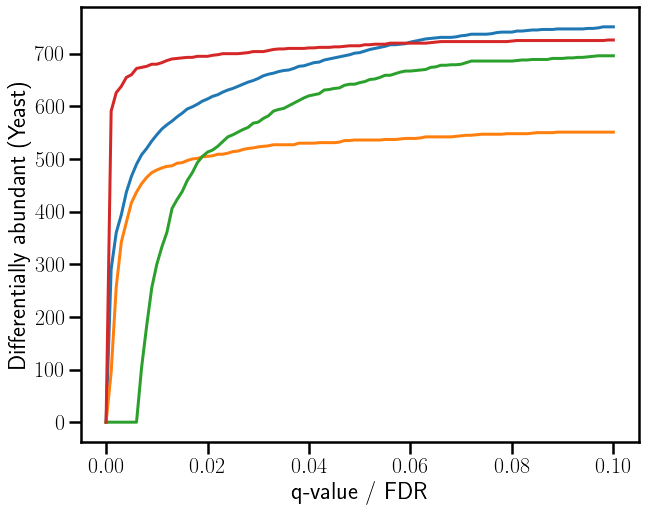

In [39]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.6
plot_pq_sns("YEAST", linewidth = 4, legend = False, specie_string = r"Yeast")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_yeast.png', bbox_inches="tight")

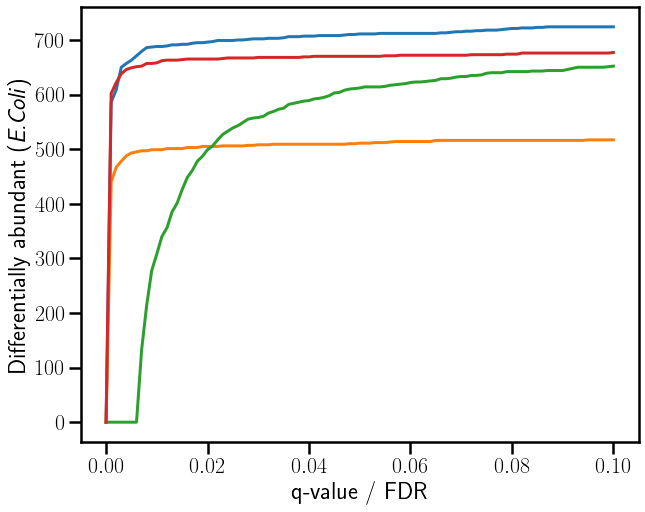

In [40]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.6
plot_pq_sns("ECOLI", linewidth = 4, legend = False, specie_string = r"\textit{E.Coli}")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_ecoli.png', bbox_inches="tight")

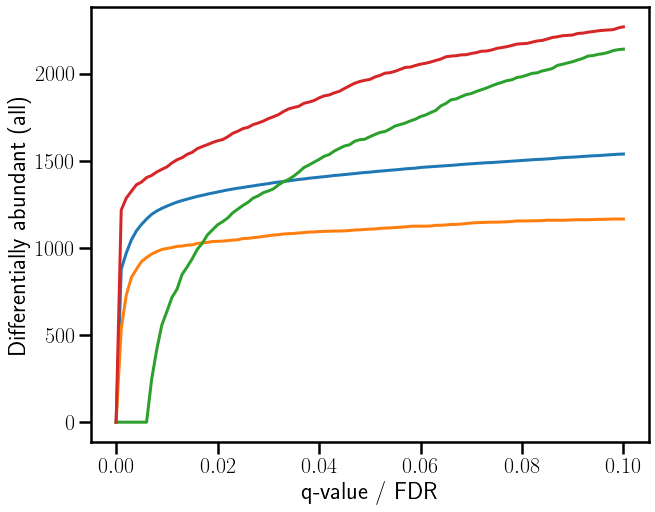

In [41]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.6
plot_pq_sns("all", linewidth = 4, legend = False, specie_string = "all")


In [42]:
def plot_pq_osw(specie, linewidth, legend):
    triq = res_osw[15] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final_osw, fc_treshold = 0.6)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms_osw, fc = 0.6)
        df_msqrob = msqrob_pq_data(msqrob_osw, fc = 0.6)
        triq.sum(axis=1).plot(ax = axs, linewidth=linewidth)

    else:
        df = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == specie], fc_treshold = 0.6)
        df_ms = msstats_pq_data(ms_osw[ms_osw.specie == specie], fc = 0.6)
        df_msqrob = msqrob_pq_data(msqrob_osw[msqrob_osw.specie == specie], fc = 0.6)
        triq[specie].plot(ax = axs, linewidth=linewidth)
    
    axs.plot(df.index, df.DE, linewidth=linewidth) # plot osw top3
    axs.plot(df_ms.index, df_ms.DE, linewidth=linewidth) # plot MSSTATS
    axs.plot(df_msqrob.index, df_msqrob.DE, linewidth=linewidth) # plot msqrob
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "msStats", "mSqRob"], fontsize = 16)
    axs.set_title(f"OSW, {specie} (fc = {0.4})",  fontsize=18)
    axs.set_xlabel("q-value / FDR", fontsize=18, fontweight='bold')
    axs.set_ylabel("n - Differentially expressed.", fontsize=18)
    

In [43]:
def plot_pq_osw_sns(specie, linewidth, legend, specie_string = None):
    triq = res_osw[10] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final_osw, fc_treshold = 0.0)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms_osw, fc = 0.0)
        df_msqrob = msqrob_pq_data(msqrob_osw, fc = 0.0)
        #triq.sum(axis=1).plot(ax = axs, linewidth=linewidth)
        sns.lineplot(data = triq.sum(axis=1).reset_index(), x = "index", y = 0, ax = axs)

    else:
        df = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == specie], fc_treshold = 0.0)
        df_ms = msstats_pq_data(ms_osw[ms_osw.specie == specie], fc = 0.0)
        df_msqrob = msqrob_pq_data(msqrob_osw[msqrob_osw.specie == specie], fc = 0.0)
        #triq[specie].plot(ax = axs, linewidth=linewidth)
        sns.lineplot(data = triq.reset_index(), x = "index", y = specie, ax = axs)
    
    #axs.plot(df.index, df.DE, linewidth=linewidth) # plot osw top3
    sns.lineplot(data = df.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_ms.index, df_ms.DE, linewidth=linewidth) # plot MSSTATS
    sns.lineplot(data = df_ms.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_msqrob.index, df_msqrob.DE, linewidth=linewidth) # plot msqrob
    sns.lineplot(data = df_msqrob.reset_index(), x = "index", y = "DE", ax = axs)
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "msStats", "mSqRob"], fontsize = 16)
    #axs.set_title(f"OSW, {specie} (fc = {0.4})",  fontsize=18, fontweight='bold')
    #axs.set_xlabel("q-value", fontsize=18, fontweight='bold')
    #axs.set_ylabel("n - Differentially expressed.", fontsize=18, fontweight='bold')
    axs.set_xlabel("q-value / FDR")
    axs.set_ylabel(f"Differentially abundant ({specie_string})")
    

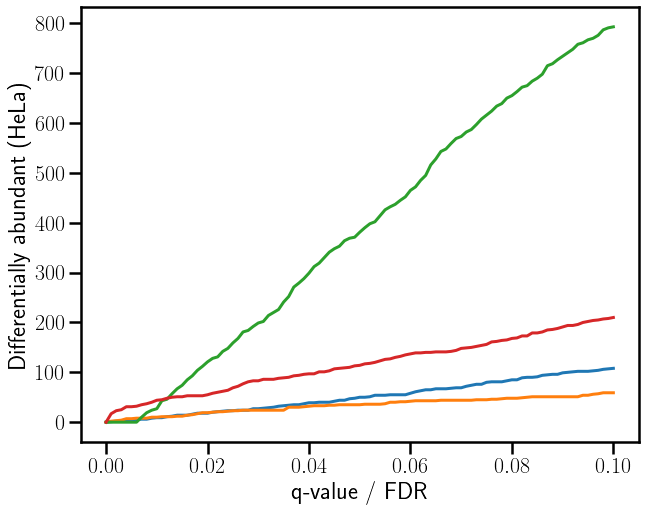

In [44]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.4
plot_pq_osw_sns("HUMAN", linewidth = 4, legend = False, specie_string = r"HeLa")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_human.png', bbox_inches="tight")

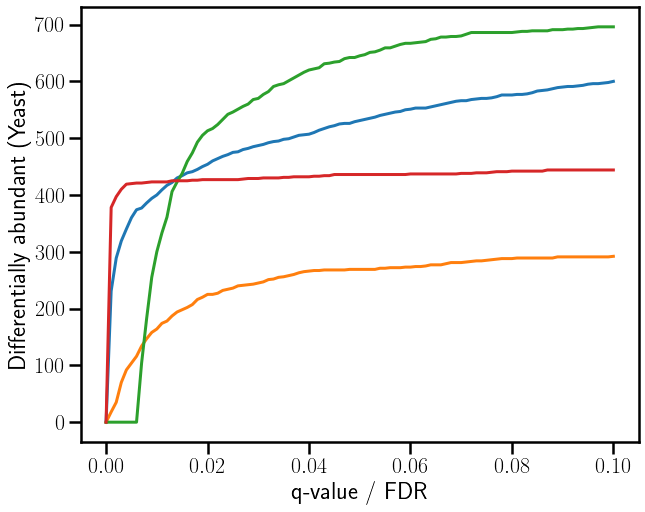

In [45]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.4
plot_pq_osw_sns("YEAST", linewidth = 4, legend = False, specie_string = "Yeast")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_yeast.png', bbox_inches="tight")

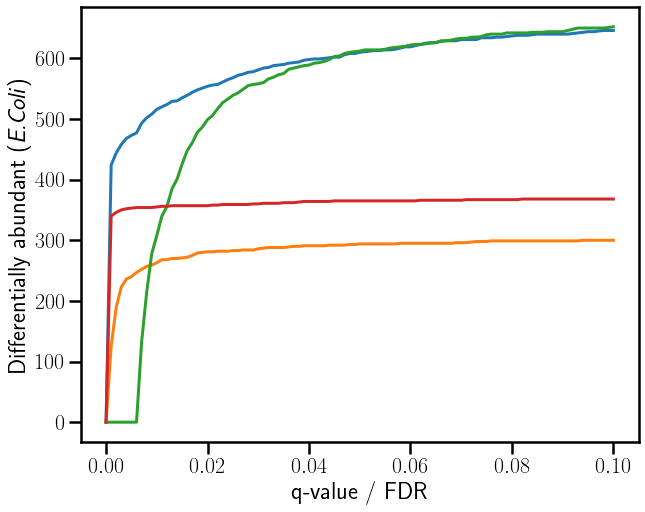

In [46]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.4
plot_pq_osw_sns("ECOLI", linewidth = 4, legend = False, specie_string = r"\textit{E.Coli}")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_ecoli.png', bbox_inches="tight")

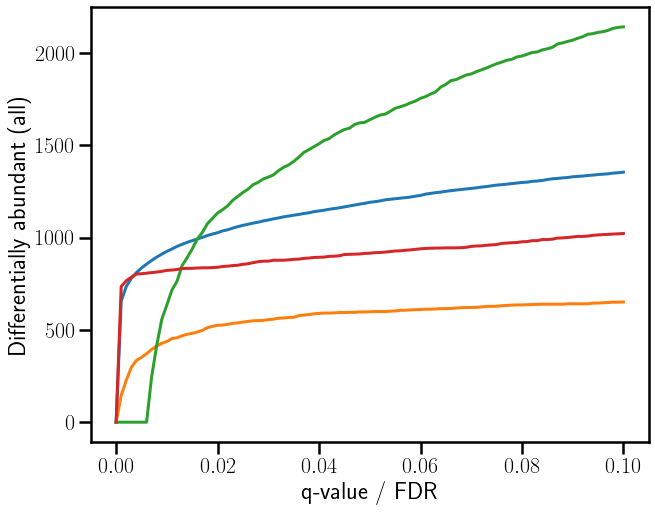

In [47]:
#fig, axs = plt.subplots(1,1, figsize = (20,15))
fig, axs = plt.subplots(1,1, figsize = (10,8))#, figsize = (20,15))

fc = 0.4
plot_pq_osw_sns("all", linewidth = 4, legend = False, specie_string = r"all")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_all.png', bbox_inches="tight")

# DIANN FP_DE 

In [48]:
#fig, axs = plt.subplots(1, 1, figsize=(20,6))
#fc = 0.4
#Rewrite this to function subplot

def plot_ratio_FP_DE(specie,linewidth, legend):
    fc = 0.6 # setting fc treshold for top3, ms, msqrobrum

    if specie == "all":
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))
        df_triq = (res[15]["HUMAN"] / 
                   res[15].sum(axis=1))
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))        
    else:
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
        df_triq = (res[15]["HUMAN"] / 
                   res[15][specie])
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

    #df_triq.plot(ax = axs, style = "b", linewidth=linewidth) # triqler data plot
    sns.lineplot(data = df_triq.reset_index(), x = "index", y = 0, ax = axs)
    #axs.plot(df.index, df.DE, "m", linewidth=linewidth) # plot osw top3
    sns.lineplot(data = df.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_ms.index, df_ms.DE, "g", linewidth=linewidth) # plot MSSTATS
    sns.lineplot(data = df_ms.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_msqrob.index, df_msqrob.DE, "r", linewidth=linewidth) # plot msqrob
    sns.lineplot(data = df_msqrob.reset_index(), x = "index", y = "DE", ax = axs)
    
    if legend == True:
        axs.legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    #axs.set_title(f"DIANN, {specie} (fc = {fc})",  fontsize=18, fontweight='bold')
    axs.set_xlabel(r"\textit{q}-value / FDR ", fontsize=34)

    axs.set_ylabel("Fraction HeLa", fontsize=38)
    axs.tick_params(axis='x', which='major', labelsize=42)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=42)
    axs.set_xlim([0,0.10])

    def abline(slope, intercept):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs.get_xlim())
        y_vals = intercept + slope * x_vals
        axs.plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0)


    
#plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
#plt.show()


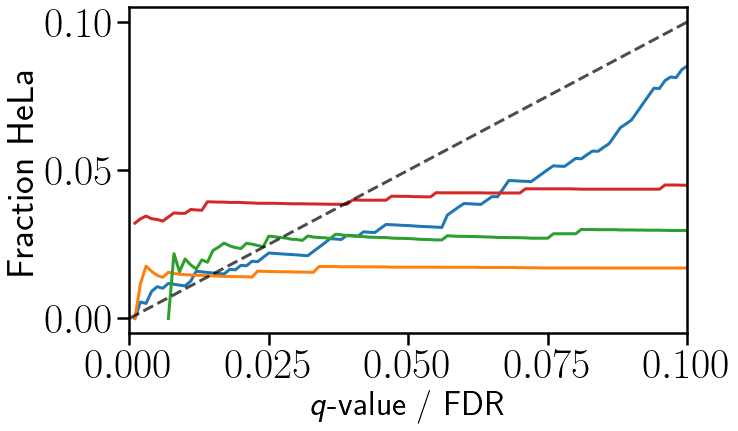

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
fc = 0.6
plot_ratio_FP_DE("YEAST", linewidth=4, legend = False)
#plt.setp(axs.get_legend().get_texts(), fontsize='30')
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_FP_DE_yeast.png', bbox_inches="tight")

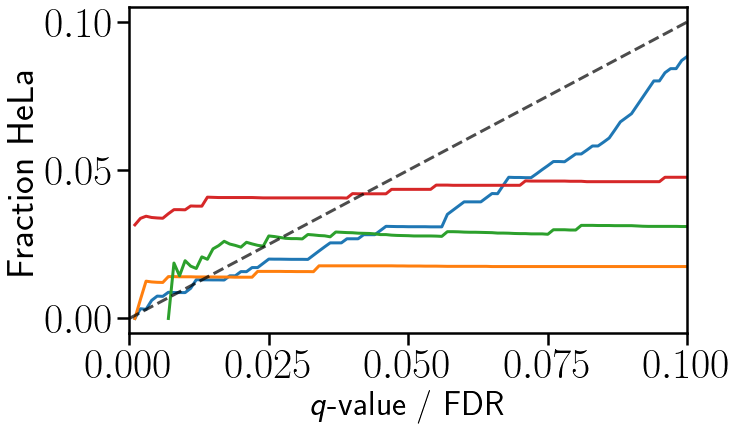

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
fc = 0.4
plot_ratio_FP_DE("ECOLI", linewidth=4, legend = False)
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_FP_DE_ecoli.png', bbox_inches="tight")

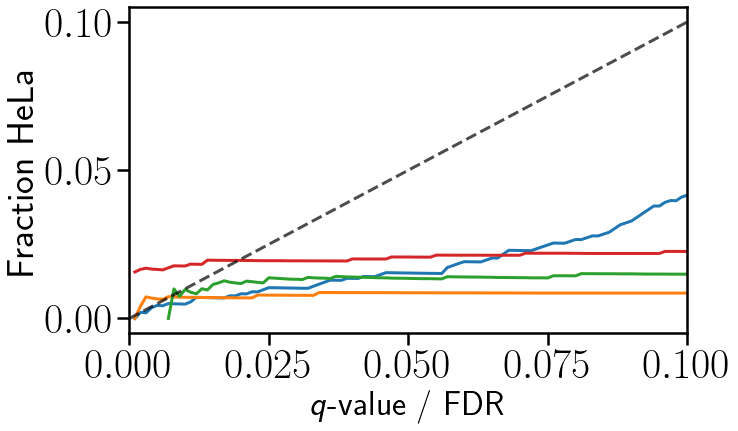

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
fc = 0.4
plot_ratio_FP_DE("all", linewidth=4, legend = False)
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_FP_DE_all.png', bbox_inches="tight")

# OSW FP_DE

In [52]:
def plot_ratio_FP_DE_osw(specie,linewidth, legend):
    fc = 0.0 # setting fc treshold of top3, msstat, msqrob

    if specie == "all":
        df = (pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final_osw, fc_treshold = fc))
        df_triq = (res_osw[10]["HUMAN"] / 
                   res_osw[10].sum(axis=1))
        df_ms = (msstats_pq_data(ms_osw[ms_osw.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms_osw, fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob_osw[msqrob_osw.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob_osw, fc = fc))        
    else:
        df = (pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == specie], fc_treshold = fc))
        df_triq = (res_osw[10]["HUMAN"] / 
                   res_osw[10][specie])
        df_ms = (msstats_pq_data(ms_osw[ms_osw.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms_osw[ms_osw.specie == specie], fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob_osw[msqrob_osw.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob_osw[msqrob_osw.specie == specie], fc = fc))        

    #df_triq.plot(ax = axs, style = "b", linewidth=linewidth) # triqler data plot
    sns.lineplot(data = df_triq.reset_index(), x = "index", y = 0, ax = axs)
    #axs.plot(df.index, df.DE, "m", linewidth=linewidth) # plot osw top3
    sns.lineplot(data = df.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_ms.index, df_ms.DE, "g", linewidth=linewidth) # plot MSSTATS
    sns.lineplot(data = df_ms.reset_index(), x = "index", y = "DE", ax = axs)
    #axs.plot(df_msqrob.index, df_msqrob.DE, "r", linewidth=linewidth) # plot msqrob
    sns.lineplot(data = df_msqrob.reset_index(), x = "index", y = "DE", ax = axs)
    
    
    
    if legend == True:
        axs.legend(labels=["Triqler", "OSW Top3", "MSstats", "MSqRob", ])
    #axs.set_title(f"OSW, {specie} (fc = {fc})",  fontsize=18, fontweight='bold')
    axs.set_xlabel(r"\textit{q}-value / FDR ", fontsize=34)
    axs.set_ylabel("Fraction HeLa", fontsize=34)
    axs.set_xlim([0,0.10])
    axs.tick_params(axis='x', which='major', labelsize=42)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=42)
    def abline(slope, intercept):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs.get_xlim())
        y_vals = intercept + slope * x_vals
        axs.plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0)



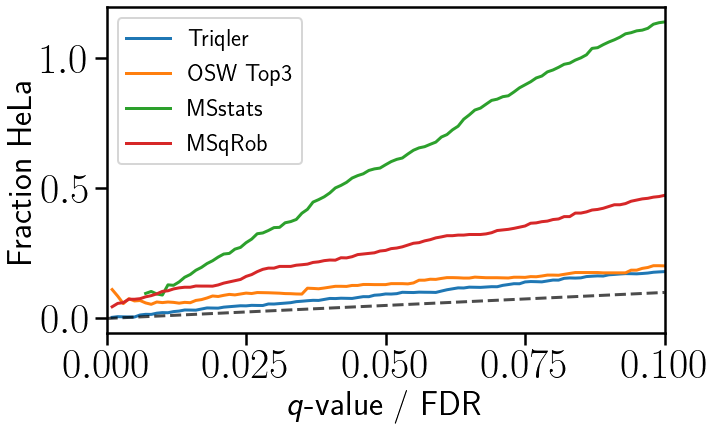

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4
plot_ratio_FP_DE_osw("YEAST", linewidth=4, legend = True)
plt.setp(axs.get_legend().get_texts(), fontsize='24')
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_FP_DE_yeast.png', bbox_inches="tight")

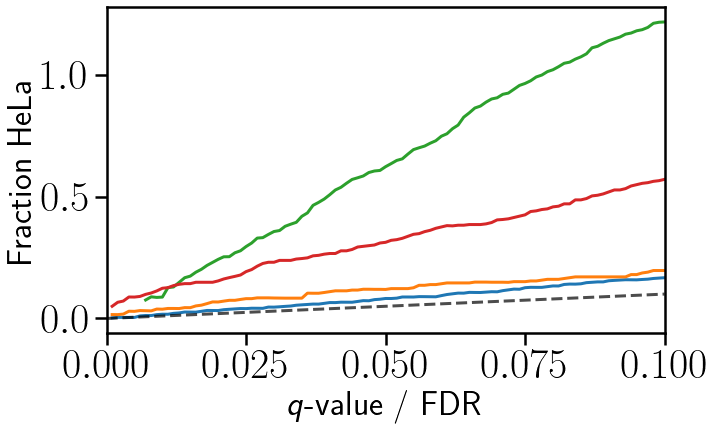

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4
plot_ratio_FP_DE_osw("ECOLI", linewidth=4, legend = False)
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_FP_DE_ecoli.png', bbox_inches="tight")

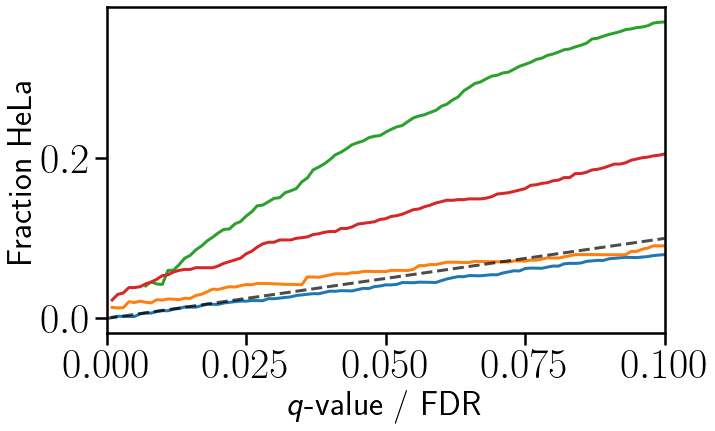

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4
plot_ratio_FP_DE_osw("all", linewidth=4, legend = False)
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_FP_DE_all.png', bbox_inches="tight")

# Protein quantity distributions
This is used to show how the data looks

# DIANN

In [56]:
import seaborn as sns

In [57]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")


In [58]:
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
q_val = 1
file = "fc_0.40"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val] # not filtered by q_value
df_triq["specie"] = df_triq.protein.map(specie_mapper)
df_triq.sort_values(by = "specie", inplace = True)
df_triq.log2_fold_change = -df_triq.log2_fold_change

fig, axs = plt.subplots(2, 2, figsize=(20,15))

sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs[0,0])
sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = True, ax = axs[0,0])
axs[0,0].set_xlim([-2, 3])
axs[0,0].set_title("Triqler")

axs[0,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,0].axvline(x = -1, color = "green", linestyle = "--")
axs[0,0].axvline(x = 2, color = "blue", linestyle = "--")

msqrob.sort_values(by = "specie", inplace = True )
msqrob["specie"] = msqrob.proteins.map(specie_mapper)
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = True, ax = axs[0,1])
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = False, ax = axs[0,1])
axs[0,1].set_title("MSqRobSum")
axs[0,1].set_xlim([-2, 3])

axs[0,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,1].axvline(x = -1, color = "green", linestyle = "--")
axs[0,1].axvline(x = 2, color = "blue", linestyle = "--")


ms.sort_values(by = "specie", inplace = True )
sns.histplot(ms.log2FC, kde = False, ax = axs[1,0], bins = 70)
sns.histplot(data=ms, x="log2FC", hue="specie", multiple="stack", bins = 70, kde = True, ax = axs[1,0])
axs[1,0].set_title("MsStats")
axs[1,0].set_xlim([-2, 3])


axs[1,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,0].axvline(x = -1, color = "green", linestyle = "--")
axs[1,0].axvline(x = 2, color = "blue", linestyle = "--")

# add -1* to reverse histograms
#sns.histplot(-1*df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("Top3")
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", kde = False)
sns.histplot(data=df_final, x="log2(A,B)", hue="specie", kde = False)

axs[1,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,1].axvline(x = -1, color = "green", linestyle = "--")
axs[1,1].axvline(x = 2, color = "blue", linestyle = "--")


fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

RuntimeError: latex was not able to process the following string:
b'log2_fold_change'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ptruong/.cache/matplotlib/tex.cache/fcf76674c6871b9f7a410aa186735d47.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./fcf76674c6871b9f7a410aa186735d47.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily log2_
                     fold_change}
No pages of output.
Transcript written on fcf76674c6871b9f7a410aa186735d47.log.




<Figure size 1440x1080 with 4 Axes>

In [59]:
df_final["log2(A,B)"] = -df_final["log2(A,B)"] 

In [60]:
df_triq[df_triq["q_value"] < 0.05]

,protein,peptides,q_value,posterior_error_prob,num_peptides,protein_id_posterior_error_prob,log2_fold_change,diff_exp_prob_0.4,1:002-Pedro,1:004-Pedro,1:006-Pedro,2:003-Pedro,2:005-Pedro,2:007-Pedro,decoy,specie
0,P0DTT0_ECOLI,AFAYGLKPIVVINK;ASGTDEAVVLVPPIR;AVAFALFGLQDR;IN...,5.342000e-09,5.342000e-09,10.0,1.830000e-11,2.0960,5.324000e-09,0.4654,0.4414,0.5506,1.9530,2.1370,2.1180,False,ECOLI
482,P06612_ECOLI,DGAAGVFLAANTFPK;LHVCGNNPTCDGYEIEEGEFR;TDSTNLSQ...,8.451000e-07,1.410000e-05,5.0,8.579000e-09,1.6180,1.409000e-05,0.6198,0.7536,0.3832,1.6160,1.7920,1.9300,False,ECOLI
483,P0ABD8_ECOLI,AFIEVGQK;AILVESGQPVEFDEPLVVIE;SPMVGTFYR,8.768000e-07,1.619000e-05,3.0,7.979000e-07,1.3840,1.539000e-05,0.5318,0.6788,0.6745,1.5690,1.5710,1.6670,False,ECOLI
485,P36659_ECOLI,FKEVAEAWEVLSDEQR;IPAGVGNGQR;TISYNLPVYNAFGMIEQEIPK,9.404000e-07,1.641000e-05,3.0,7.979000e-07,1.4790,1.562000e-05,0.4948,0.6326,0.6983,1.8610,1.5650,1.5710,False,ECOLI
486,P25714_ECOLI,ELNSTQPFQLLETSPQFIYQAQSGLTGR;GGDVEQALLPAYPK;RG...,9.752000e-07,1.787000e-05,6.0,1.702000e-09,1.5130,1.786000e-05,0.5543,0.7717,0.5079,1.5300,1.5920,1.8900,False,ECOLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,P38777_YEAST,ISELVPDHPQFK;MIFIYGASDQAVPSVR;VSVVISGYSFTEPDPE...,4.755000e-04,7.595000e-03,3.0,7.979000e-07,-0.7259,7.595000e-03,1.2050,1.3310,1.3330,0.8181,0.7191,0.7950,False,YEAST
1098,P32457_YEAST,LFSSLPYAVIGSNDIVENYSGNQVR;LNLNVIDTEGFGDFLNNDQK...,4.690000e-04,7.442000e-03,4.0,6.214000e-08,-0.7517,7.442000e-03,1.2500,1.2890,1.3400,0.7799,0.7135,0.8325,False,YEAST
1097,P39929_YEAST,IVNNNVNAAPISENK;TQITNQENEAR,4.627000e-04,7.122000e-03,2.0,2.913000e-05,-0.8006,7.093000e-03,1.2590,1.3230,1.4010,0.6501,0.8135,0.8103,False,YEAST
1108,P28000_YEAST,IQTYGETTAVDALQK;LLTQATSEDGTSASFQIVEEDHTLGNALR;...,5.438000e-04,1.000000e-02,3.0,7.979000e-07,-0.7583,1.000000e-02,1.2490,1.3230,1.4050,0.7931,0.6499,0.8360,False,YEAST


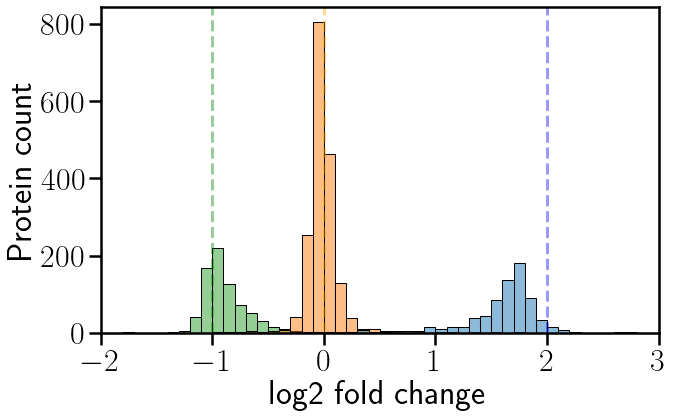

In [61]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))

fig, axs = plt.subplots(1, 1, figsize=(10,6))


#fig, axs = plt.subplots(1,1)

#sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs)
#sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = False, ax = axs)
sns.histplot(data=df_triq[df_triq["q_value"] < 1], x="log2_fold_change", hue="specie", kde = False, ax = axs,
             bins = np.histogram_bin_edges(df_triq[df_triq["q_value"] < 0.05].log2_fold_change, bins=50, range=(-2,3), weights=None))
axs.set_xlim([-2, 3])
#axs.set_title("DIANN, Triqler", fontsize=22, fontweight='bold')


axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)

axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

#plt.setp(axs.get_legend().get_texts(), fontsize='30')
plt.legend([],[], frameon=False)

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_triqler_intensity.png', bbox_inches="tight")

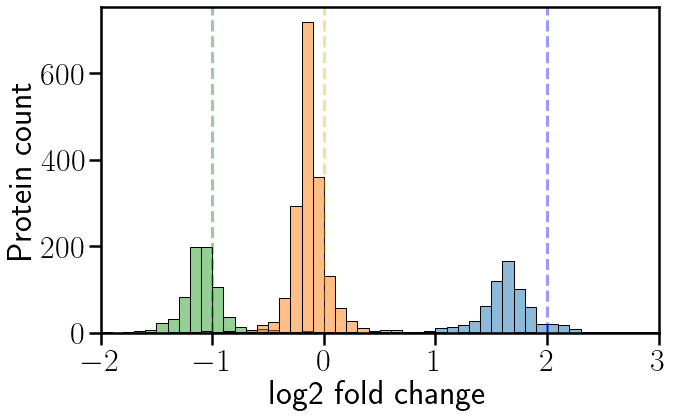

In [62]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))


msqrob.sort_values(by = "specie", inplace = True )
msqrob["specie"] = msqrob.proteins.map(specie_mapper)
sns.histplot(msqrob[msqrob.adjPval < 1], x = "logFC", hue = "specie",kde = False, ax = axs, 
            bins = np.histogram_bin_edges(msqrob[msqrob.adjPval < 0.05].logFC, bins=50, range=(-2,3), weights=None))
#sns.histplot(msqrob, x = "logFC", hue = "specie",kde = False, ax = axs[0,1])
#axs.set_title("DIANN, MSqRobSum", fontsize=18, fontweight='bold')
axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
plt.setp(axs.get_legend().get_texts(), fontsize='16')

plt.legend([],[], frameon=False)


axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')


axs.set_xlim([-2, 3])

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_msqrobsum_intensity.png', bbox_inches="tight")

In [63]:
ms

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,specie
583,P0A8A2_ECOLI,T2-T1,1.145167,0.226288,5.060651,2.0,0.036899,0.064178,NaN,0.000000,0.000000,ECOLI
640,P0A9M8_ECOLI,T2-T1,1.454468,0.011629,125.069539,2.0,0.000064,0.006375,NaN,0.107843,0.107843,ECOLI
641,P0A9N4_ECOLI,T2-T1,1.006887,0.072231,13.939820,2.0,0.005107,0.016125,NaN,0.000000,0.000000,ECOLI
642,P0A9P0_ECOLI,T2-T1,1.634836,0.028685,56.992881,2.0,0.000308,0.006726,NaN,0.077778,0.077778,ECOLI
643,P0A9P4_ECOLI,T2-T1,1.245469,0.086468,14.403760,2.0,0.004785,0.015583,NaN,0.083333,0.083333,ECOLI
...,...,...,...,...,...,...,...,...,...,...,...,...
2230,Q12125_YEAST,T2-T1,-0.828702,0.085277,-9.717784,2.0,0.010424,0.026088,NaN,0.000000,0.000000,YEAST
1053,P21264_YEAST,T2-T1,-0.841339,0.013251,-63.491960,2.0,0.000248,0.006726,NaN,0.033333,0.033333,YEAST
1052,P21242_YEAST,T2-T1,-0.868495,0.124855,-6.956013,2.0,0.020048,0.041405,NaN,0.000000,0.000000,YEAST
1047,P20967_YEAST,T2-T1,-0.920099,0.070605,-13.031671,2.0,0.005837,0.017494,NaN,0.089744,0.089744,YEAST


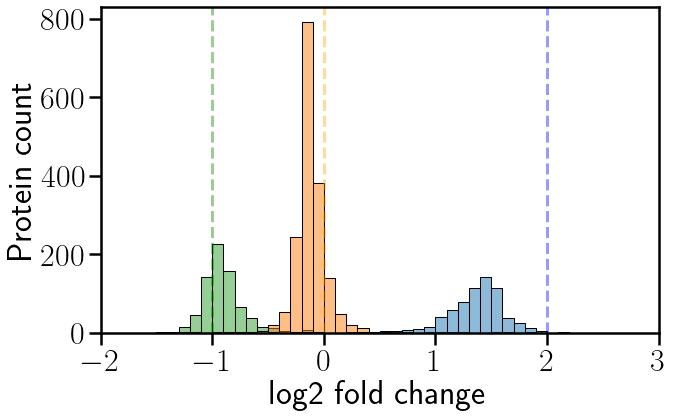

In [64]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))


ms.sort_values(by = "specie", inplace = True )
#sns.histplot(ms.log2FC, kde = False, ax = axs, bins = 70)
sns.histplot(data=ms[ms["adj.pvalue"] < 1], x="log2FC", hue="specie", kde = False, ax = axs,
            bins = np.histogram_bin_edges(ms[ms["adj.pvalue"] < 0.05].log2FC, bins=50, range=(-2,3), weights=None))
#sns.histplot(data=ms, x="log2FC", hue="specie", multiple="stack", bins = 70, kde = True, ax = axs)
#axs.set_title("DIANN, MSstats", fontsize=18, fontweight='bold')

axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
plt.legend([],[], frameon=False)

axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')


axs.set_xlim([-2, 3])

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_msstats_intensity.png', bbox_inches="tight")

In [65]:
df_final["-log2(A,B)"] = -df_final["log2(A,B)"]

In [66]:
df_final[df_final.q < 0.01]

1          2         p         q  log2(A,B)  \
specie ProteinName                                                         
ECOLI  P00350_ECOLI  10.761654  12.549982  0.000007  0.000161   1.788328   
       P00363_ECOLI   9.726499  11.560614  0.000012  0.000164   1.834115   
       P00393_ECOLI   7.508624   9.394929  0.001674  0.003231   1.886305   
       P00448_ECOLI   7.396541   9.259683  0.000074  0.000341   1.863142   
       P00452_ECOLI   7.326490   9.178279  0.000167  0.000595   1.851789   
...                        ...        ...       ...       ...        ...   
YEAST  Q12746_YEAST   8.410071   7.583270  0.000485  0.001289  -0.826801   
       Q12754_YEAST   7.460877   6.634726  0.001350  0.002713  -0.826151   
       Q96VH4_YEAST   9.834721   8.958579  0.000464  0.001254  -0.876142   
       Q99258_YEAST   8.279248   7.065686  0.000037  0.000244  -1.213562   
       Q99383_YEAST   9.587492   8.684578  0.002081  0.003884  -0.902914   

                     -log2(A,B)  
specie ProteinName               
ECOLI  P00350_ECOLI   -1.788328  
       P00363_ECOLI   -1.834115  
       P00393_ECOLI   -1.886305  
       P00448_ECOLI   -1.863142  
       P00452_ECOLI   -1.851789  
...                         ...  
YEAST  Q12746_YEAST    0.826801  
       Q12754_YEAST    0.826151  
       Q96VH4_YEAST    0.876142  
       Q99258_YEAST    1.213562  
       Q99383_YEAST    0.902914  

[997 rows x 6 columns]

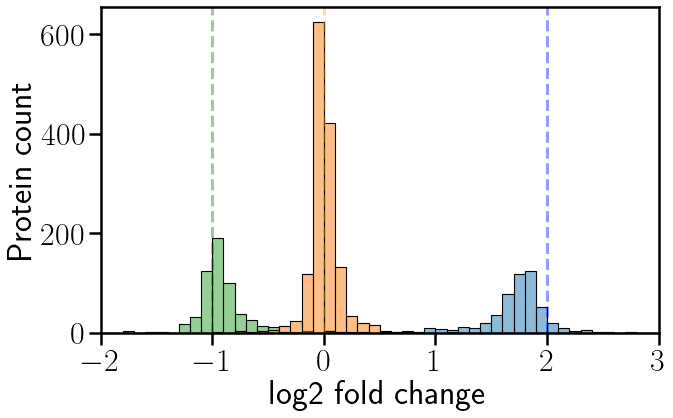

In [67]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))

# add -1* to reverse histograms
#sns.histplot(-1*df_final["log2(A,B)"], kde = False, ax = axs)
axs.set_xlim([-2, 3])
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
sns.histplot(data=df_final[df_final.q < 1], x="log2(A,B)", hue="specie", kde = False, 
            bins = np.histogram_bin_edges(df_final[df_final.q < 0.05]["log2(A,B)"], bins=50, range=(-2,3), weights=None))

#axs.set_title("DIANN, Top3", fontsize=18, fontweight='bold')

axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
plt.legend([],[], frameon=False)


axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')


axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_top3_intensity.png', bbox_inches="tight")

# OSW - Protein quantity distributions

In [68]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
q_val = 1
file = "fc_0.40"
df_triq_osw = parse_triqler(file)
df_triq_osw["decoy"] = df_triq_osw.protein.map(decoy_mapper)
df_triq_osw = df_triq_osw[df_triq_osw.decoy == False] # remove decoy proteins.
df_triq_osw = df_triq_osw[df_triq_osw.q_value < q_val]
df_triq_osw["specie"] = df_triq_osw.protein.map(specie_mapper)
df_triq_osw.sort_values(by = "specie", inplace = True)
df_triq_osw.log2_fold_change = -df_triq_osw.log2_fold_change

In [69]:
df_final_osw["log2(A,B)"] =  -df_final_osw["log2(A,B)"] 

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

sns.histplot(df_triq_osw["log2_fold_change"], kde = False, ax = axs[0,0])
sns.histplot(data=df_triq_osw, x="log2_fold_change", hue="specie", multiple="stack", kde = True, ax = axs[0,0])
axs[0,0].set_xlim([-2, 3])
axs[0,0].set_title("Triqler")

axs[0,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,0].axvline(x = -1, color = "green", linestyle = "--")
axs[0,0].axvline(x = 2, color = "blue", linestyle = "--")

msqrob_osw.sort_values(by = "specie", inplace = True )
msqrob_osw["specie"] = msqrob_osw.proteins.map(specie_mapper)
#sns.histplot(msqrob_osw, x = "logFC", hue = "specie",kde = True, ax = axs[0,1])
sns.histplot(msqrob_osw, x = "logFC", hue = "specie",kde = False, ax = axs[0,1])
axs[0,1].set_title("MSqRobSum")
axs[0,1].set_xlim([-2, 3])

axs[0,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,1].axvline(x = -1, color = "green", linestyle = "--")
axs[0,1].axvline(x = 2, color = "blue", linestyle = "--")

ms_osw.sort_values(by = "specie", inplace = True )
#sns.histplot(ms_osw.log2FC, kde = False, ax = axs[1,0], bins = 70)
sns.histplot(data=ms_osw, x="log2FC", hue="specie", bins = 70, kde = False, ax = axs[1,0])
axs[1,0].set_title("MsStats")
axs[1,0].set_xlim([-2, 3])


axs[1,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,0].axvline(x = -1, color = "green", linestyle = "--")
axs[1,0].axvline(x = 2, color = "blue", linestyle = "--")

# add -1* to reverse histograms
#sns.histplot(-1*df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("Top3")
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", kde = False)
sns.histplot(data=df_final_osw, x="log2(A,B)", hue="specie", kde = False)

axs[1,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,1].axvline(x = -1, color = "green", linestyle = "--")
axs[1,1].axvline(x = 2, color = "blue", linestyle = "--")


fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

RuntimeError: latex was not able to process the following string:
b'log2_fold_change'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ptruong/.cache/matplotlib/tex.cache/fcf76674c6871b9f7a410aa186735d47.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./fcf76674c6871b9f7a410aa186735d47.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily log2_
                     fold_change}
No pages of output.
Transcript written on fcf76674c6871b9f7a410aa186735d47.log.




<Figure size 1440x1080 with 4 Axes>

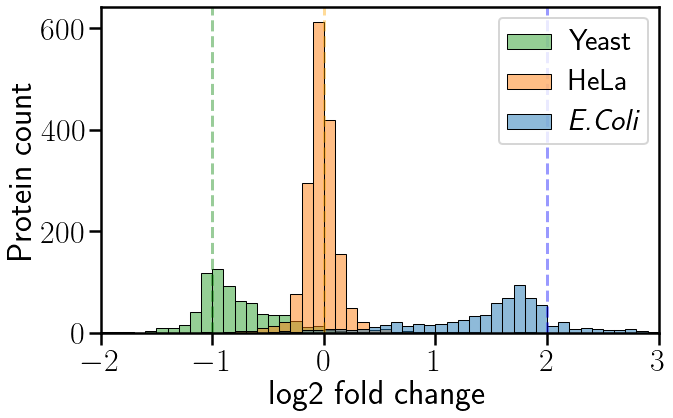

In [71]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))

#sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs)
g = sns.histplot(data=df_triq_osw[df_triq_osw["q_value"] < 1], x="log2_fold_change", hue="specie", kde = False, ax = axs, 
                bins = np.histogram_bin_edges(df_triq_osw[df_triq_osw["q_value"] < 0.05].log2_fold_change, bins=50, range=(-2,3), weights=None))
g.legend_.set_title(None)

axs.set_xlim([-2, 3])
#axs.set_title("OSW, Triqler", fontsize=18, fontweight='bold')
axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
#plt.setp(axs.get_legend().get_texts(), fontsize='16')
#plt.legend([],[], frameon=False)

plt.legend(loc='upper right', labels=['Yeast', "HeLa",  r'\textit{E.Coli}'])
plt.setp(axs.get_legend().get_texts(), fontsize='30')
#plt.setp(axs.get_legend().get_texts(), fontsize='30')

axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

#plt.setp(axs.get_legend().get_texts(), fontsize='24')

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_triqler_intensity.png', bbox_inches="tight")

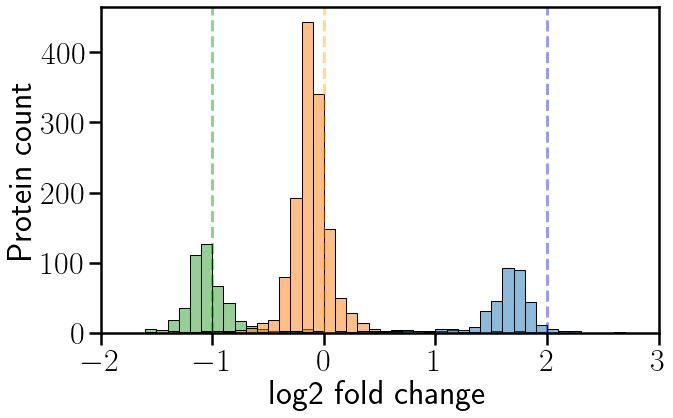

In [72]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))

msqrob_osw.sort_values(by = "specie", inplace = True )
msqrob_osw["specie"] = msqrob_osw.proteins.map(specie_mapper)
sns.histplot(msqrob_osw[msqrob_osw.adjPval < 1], x = "logFC", hue = "specie",kde = False, ax = axs,
            bins = np.histogram_bin_edges(msqrob_osw[msqrob_osw.adjPval < 0.05].logFC, bins=50, range=(-2,3), weights=None))
#axs.set_title("OSW, MSqRobSum", fontsize=18, fontweight='bold')
axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
#plt.setp(axs.get_legend().get_texts(), fontsize='16')
plt.legend([],[], frameon=False)


axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')

axs.set_xlim([-2, 3])

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_msqrobsum_intensity.png', bbox_inches="tight")


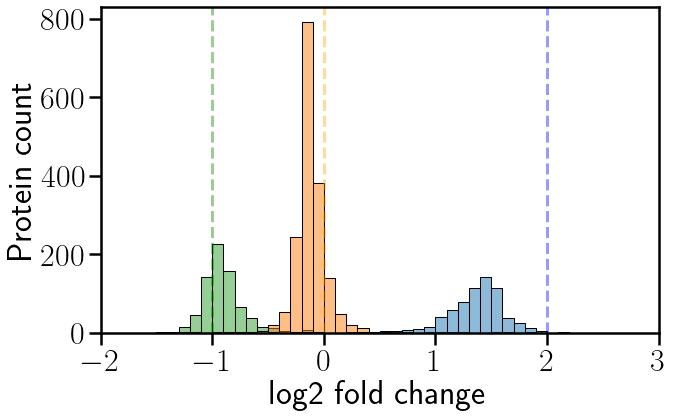

In [73]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15))
fig, axs = plt.subplots(1, 1, figsize=(10,6))

ms_osw.sort_values(by = "specie", inplace = True )
#sns.histplot(ms_osw.log2FC, kde = False, ax = axs[1,0], bins = 70)
sns.histplot(data=ms_osw[ms_osw["adj.pvalue"] < 1], x="log2FC", hue="specie", kde = False, ax = axs,
            bins = np.histogram_bin_edges(ms_osw[ms_osw["adj.pvalue"] < 0.05]["log2FC"], bins=50, range=(-2,3), weights=None))
#axs.set_title("OSW, MSstats", fontsize=18, fontweight='bold')
axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
#plt.setp(axs.get_legend().get_texts(), fontsize='16')
plt.legend([],[], frameon=False)

axs.set_xlim([-2, 3])


axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')


axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_msstats_intensity.png', bbox_inches="tight")


In [74]:
df_final_osw["-log2(A,B)"] = -df_final_osw["log2(A,B)"]

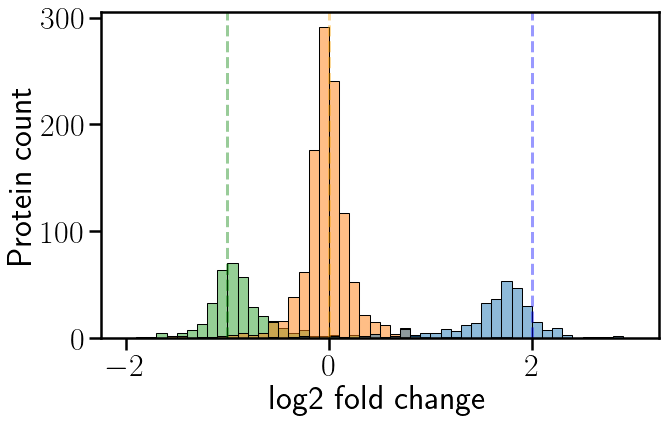

In [75]:
#fig, axs = plt.subplots(1, 1, figsize=(20,15)

fig, axs = plt.subplots(1, 1, figsize=(10,6))

#axs[1,1].set_title("Top3")
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
#sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", kde = False)
sns.histplot(data=-1*df_final_osw[df_final_osw.q < 1], x="-log2(A,B)", hue="specie", kde = False,
            bins = np.histogram_bin_edges(df_final_osw[df_final_osw.q < 0.05]["log2(A,B)"], bins=50, range=(-2,3), weights=None))

#axs.set_title("OSW, Top3", fontsize=18, fontweight='bold')
axs.set_xlabel("log2 fold change", fontsize=34)
axs.set_ylabel("Protein count", fontsize=34)
#plt.setp(axs.get_legend().get_texts(), fontsize='16')
plt.legend([],[], frameon=False)


axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
axs.tick_params(axis='y', which='major', labelsize=32)

plt.setp(axs.get_legend().get_texts(), fontsize='30')

axs.axvline(x = 0, color = "orange", linestyle = "--", alpha = 0.4)
axs.axvline(x = -1, color = "green", linestyle = "--", alpha = 0.4)
axs.axvline(x = 2, color = "blue", linestyle = "--", alpha = 0.4)

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_top3_intensity.png', bbox_inches="tight")



# DE specie vs DE human

This plot shows how many true positives we get compares to false positives.

In [76]:

#Rewrite this to function subplot

def plot_de_specie_xy(specie_x, specie_y,linewidth, legend, specie_x_string, specie_y_string):
    fc = 0.0
    df_triq_x = res[15][specie_x]
    df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)

    df_triq_y = res[15][specie_y]
    df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)

    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs.plot(df_triq_x.values, df_triq_y.values,linewidth=linewidth)
    axs.plot(df_x.values, df_y.values,linewidth=linewidth)
    axs.plot(df_ms_x.values, df_ms_y.values,linewidth=linewidth)
    axs.plot(df_msqrob_x.values, df_msqrob_y.values,linewidth=linewidth)
    
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "MSstats", "mSqRob"])
    #axs.set_title(f"DIANN, fc = {fc}",  fontsize=18, fontweight='bold')
    axs.set_xlabel(f"{specie_x_string}",  fontsize=28)
    axs.set_ylabel(f"{specie_y_string}",  fontsize=28)
    axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=32)
    axs.set_xlim(-1, 50)

#plot_de_specie_xy(specie_x = "HUMAN", specie_y = "YEAST", ax_n = 1)

#plt.suptitle(f"Differentially expressed proteins specie to human ratio")# + specie)
#plt.show()


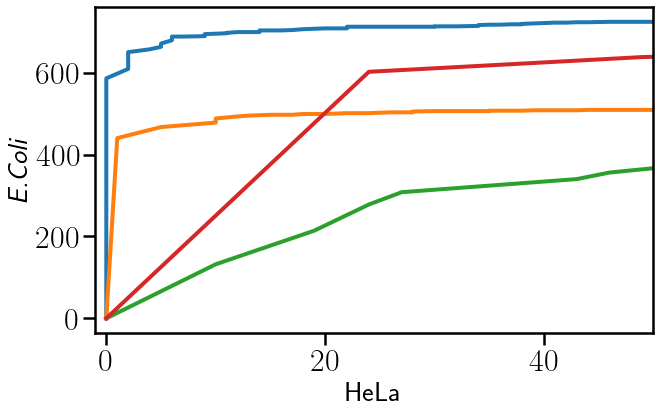

In [77]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4 

plot_de_specie_xy(specie_x = "HUMAN", specie_y = "ECOLI", linewidth=4, legend = False, specie_x_string = "HeLa", specie_y_string =  r'\textit{E.Coli}')

#plt.setp(axs.get_legend().get_texts(), fontsize='30')
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_human_vs_ecoli.png', bbox_inches="tight")


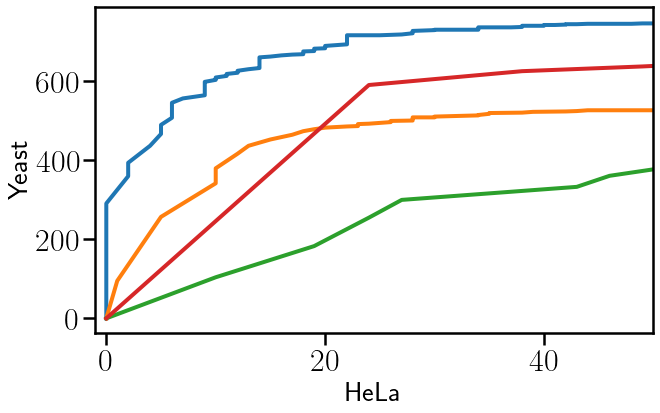

In [78]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4 

plot_de_specie_xy(specie_x = "HUMAN", specie_y = "YEAST", linewidth=4, legend = False, specie_x_string = "HeLa", specie_y_string = "Yeast")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_human_vs_yeast.png', bbox_inches="tight")

In [79]:


#Rewrite this to function subplot

def plot_de_all_vs_human(linewidth, legend):
    fc = 0.0
    df_triq_x = res[15]["HUMAN"]
    df_x = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
    
    df_triq_y = res[15][["ECOLI", "YEAST"]].sum(axis = 1)
    df_y = pq_data(df_final[df_final.index.get_level_values("specie").isin(["ECOLI", "YEAST"])], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms[ms.specie.isin(["ECOLI", "YEAST"])], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie.isin(["ECOLI", "YEAST"])], fc = fc)
    
    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs.plot(df_triq_x.values, df_triq_y.values,linewidth=linewidth)
    axs.plot(df_x.values, df_y.values,linewidth=linewidth)
    axs.plot(df_ms_x.values, df_ms_y.values,linewidth=linewidth)
    axs.plot(df_msqrob_x.values, df_msqrob_y.values,linewidth=linewidth)
    
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "MSstats", "MSqRob"], loc = 1)
    #axs.set_title(f"DIANN, fc = {fc}",  fontsize=18, fontweight='bold')
    axs.set_xlabel(f"Differential HeLa Proteins",  fontsize=28)
    #axs.set_ylabel(f"ECOLI + YEAST",  fontsize=28)
    axs.set_ylabel(r"Differential \textit{E.Coli} + Yeast Proteins",  fontsize=24)
    axs.tick_params(axis='x', which='major', labelsize=42)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=42)
    axs.set_xlim(-1, 50)
    

#plot_de_specie_xy(specie_x = "HUMAN", specie_y = "YEAST", ax_n = 1)

#plt.suptitle(f"Differentially expressed proteins specie to human ratio")# + specie)
#plt.show()




In [80]:
pq_data(df_final[df_final.index.get_level_values("specie").isin(["ECOLI", "YEAST"])], fc_treshold = fc)

,DE
0.000,0
0.001,535
0.002,724
0.003,820
0.004,868
...,...
0.096,1065
0.097,1065
0.098,1065
0.099,1065


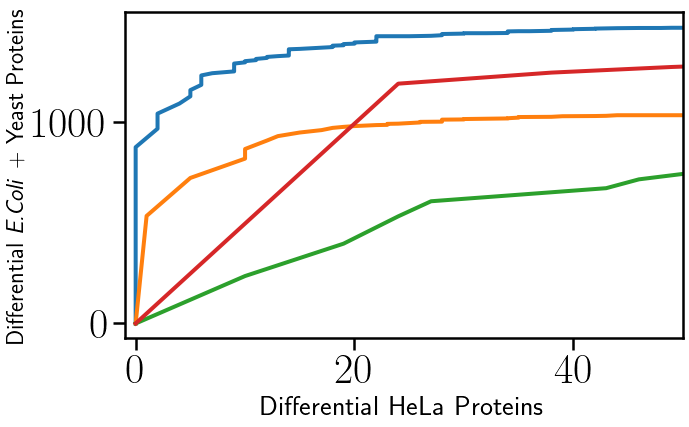

In [81]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
fc = 0.4 
plot_de_all_vs_human( linewidth=4, legend = False)
#plt.setp(axs.get_legend().get_texts(), fontsize='30')

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/diann_de_human_vs_ecoli_and_yeast.png', bbox_inches="tight")

# OSW DE specie vs DE human


In [82]:

def plot_de_specie_xy_osw(specie_x, specie_y,linewidth, legend, specie_x_string, specie_y_string):
    fc = 0.0
    df_triq_x = res_osw[10][specie_x]
    df_x = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == specie_x], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms_osw[ms_osw.specie == specie_x], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob_osw[msqrob_osw.specie == specie_x], fc = fc)

    df_triq_y = res_osw[10][specie_y]
    df_y = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == specie_y], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms_osw[ms_osw.specie == specie_y], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob_osw[msqrob_osw.specie == specie_y], fc = fc)

    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs.plot(df_triq_x.values, df_triq_y.values,linewidth=linewidth)
    axs.plot(df_x.values, df_y.values,linewidth=linewidth)
    axs.plot(df_ms_x.values, df_ms_y.values,linewidth=linewidth)
    axs.plot(df_msqrob_x.values, df_msqrob_y.values,linewidth=linewidth)
    
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "MSstats", "MSqRob"])

    #axs.set_title(f"OSW - fc = {fc}",  fontsize=18, fontweight='bold')
    #axs.set_xlabel(f"n - Differentially expressed {specie_x}",  fontsize=18, fontweight='bold')
    #axs.set_ylabel(f"n - Differentially expressed {specie_y}",  fontsize=18, fontweight='bold')
    axs.set_xlabel(f"{specie_x_string}",  fontsize=28)
    axs.set_ylabel(f"{specie_y_string}",  fontsize=28)
    axs.tick_params(axis='x', which='major', labelsize=32)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=32)
    axs.set_xlim(-1, 50)


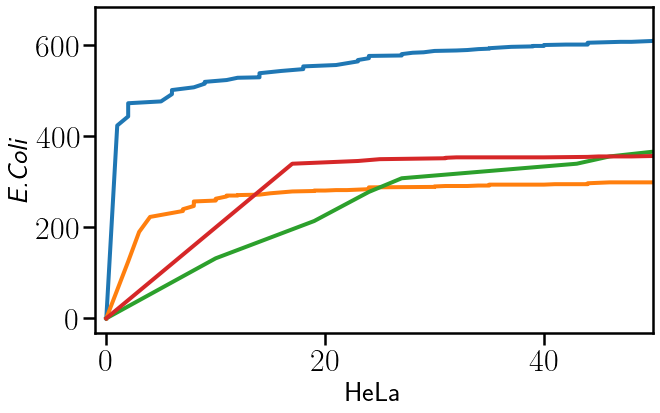

In [83]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4 

plot_de_specie_xy_osw(specie_x = "HUMAN", specie_y = "ECOLI", linewidth=4, legend = False, specie_x_string = "HeLa", specie_y_string = r'\textit{E.Coli}')
#plt.setp(axs.get_legend().get_texts(), fontsize='30')
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_human_vs_ecoli.png', bbox_inches="tight")

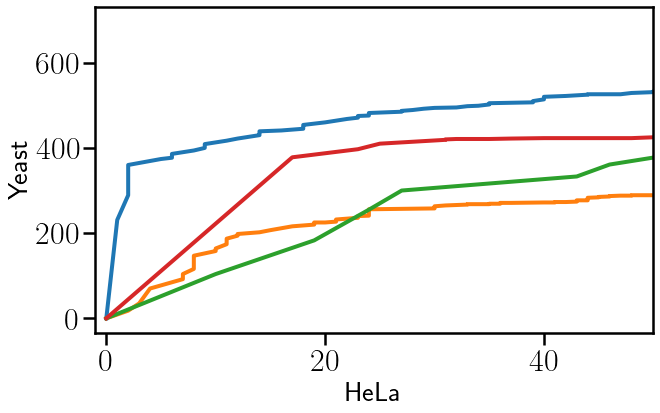

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
#fc = 0.4 

plot_de_specie_xy_osw(specie_x = "HUMAN", specie_y = "YEAST", linewidth=4, legend = False, specie_x_string = "HeLa", specie_y_string = "Yeast")
plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_human_vs_yeast.png', bbox_inches="tight")

In [85]:

def plot_de_all_vs_human_osw(linewidth, legend):
    fc = 0.0
    df_triq_x = res_osw[10]["HUMAN"]
    df_x = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms_osw[ms_osw.specie == "HUMAN"], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob_osw[msqrob_osw.specie == "HUMAN"], fc = fc)

    df_triq_y = res_osw[10][["ECOLI","YEAST"]].sum(axis = 1)
    df_y = pq_data(df_final_osw[df_final_osw.index.get_level_values("specie").isin(["ECOLI","YEAST"])], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms_osw[ms_osw.specie.isin(["ECOLI","YEAST"])], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob_osw[msqrob_osw.specie.isin(["ECOLI","YEAST"])], fc = fc)

    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs.plot(df_triq_x.values, df_triq_y.values,linewidth=linewidth)
    axs.plot(df_x.values, df_y.values,linewidth=linewidth)
    axs.plot(df_ms_x.values, df_ms_y.values,linewidth=linewidth)
    axs.plot(df_msqrob_x.values, df_msqrob_y.values,linewidth=linewidth)
    
    if legend == True:
        axs.legend(labels=["Triqler", "Top3", "MSstats", "MSqRob"], loc =  1)

    #axs.set_title(f"OSW - fc = {fc}",  fontsize=18, fontweight='bold')
    #axs.set_xlabel(f"n - Differentially expressed {specie_x}",  fontsize=18, fontweight='bold')
    #axs.set_ylabel(f"n - Differentially expressed {specie_y}",  fontsize=18, fontweight='bold')
    #axs.set_xlabel(f"HeLa",  fontsize=28)
    #axs.set_ylabel(r"\textit{E.Coli} + Yeast",  fontsize=28)
    
    axs.set_xlabel(f"Differential HeLa Proteins",  fontsize=28)
    axs.set_ylabel(r"Differential \textit{E.Coli} + Yeast Proteins",  fontsize=24)
    axs.tick_params(axis='x', which='major', labelsize=42)#labelrotation=90)
    axs.tick_params(axis='y', which='major', labelsize=42)
    axs.set_xlim(-1, 50)


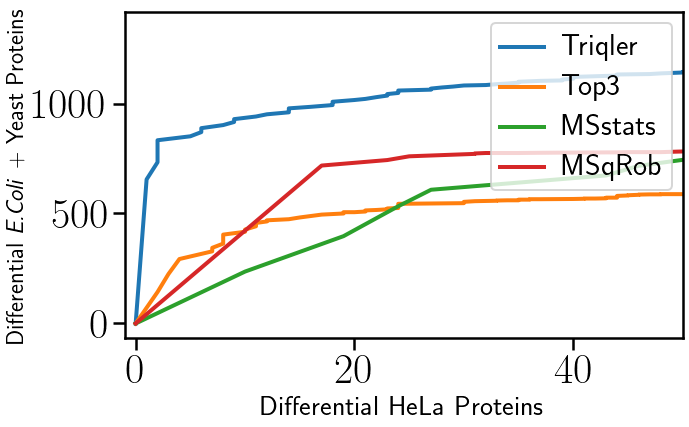

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
#fc = 0.4 
plot_de_all_vs_human_osw(linewidth=4, legend = True)
plt.setp(axs.get_legend().get_texts(), fontsize='30')

plt.savefig('/home/ptruong/git/dia_sum/result/report_plots_filtered/osw_de_human_vs_ecoli_and_yeast.png', bbox_inches="tight")

# LFQ Scatter plot



In [87]:
df_final["log2(A)"] = df_final["1"] #log(A)
df_final["log2(B)"] = df_final["2"] #log(A)

Text(0.5, 1.0, 'std/mu ratio for log-transformed peptide values')

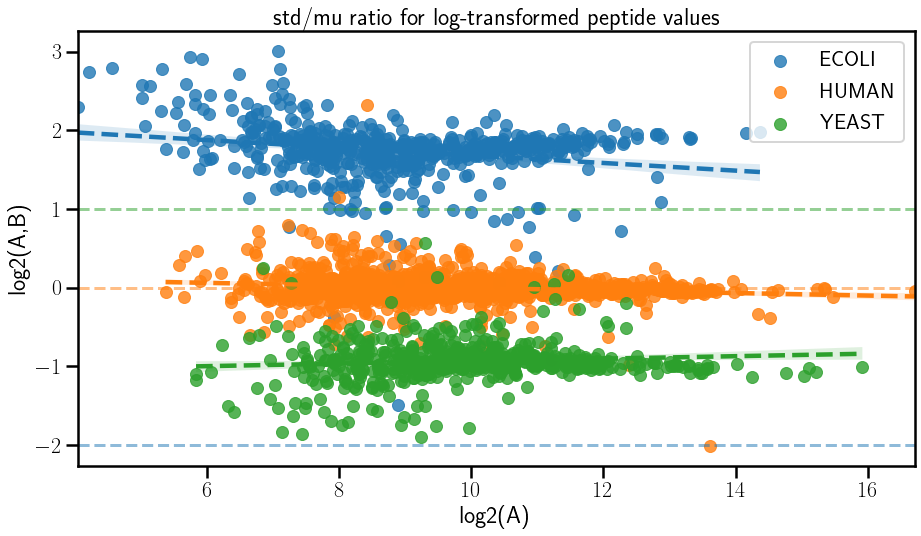

In [88]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_final, x = "log2(B)", y = "log2(A,B)", alpha = 0.7, hue = "specie")
df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "YEAST")
ax.legend()
ax.axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
#ax.grid()
#plt.legend(labels=['HUMAN (sample 1)', 'YEAST (sample 1)', "ECOLI (sample 1)", "HUMAN (sample 2)", "YEAST (sample 2)", "ECOLI (sample 2)"])
plt.title("std/mu ratio for log-transformed peptide values")

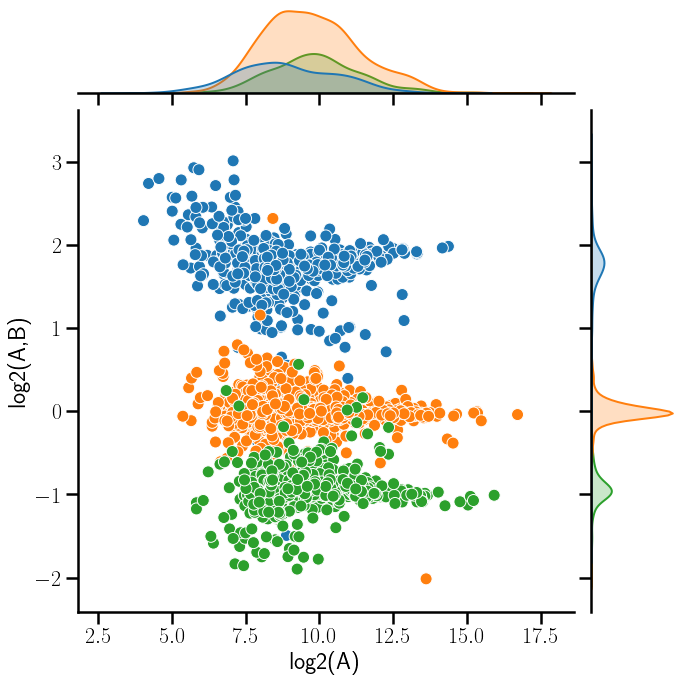

In [89]:

g = sns.jointplot(data = df_final, x = "log2(A)", y = "log2(A,B)", hue = "specie", height = 10)#, line_kws = {"ls":"--"}, label ="ECOLI")
g.ax_joint.legend().set_visible(False)

No handles with labels found to put in legend.


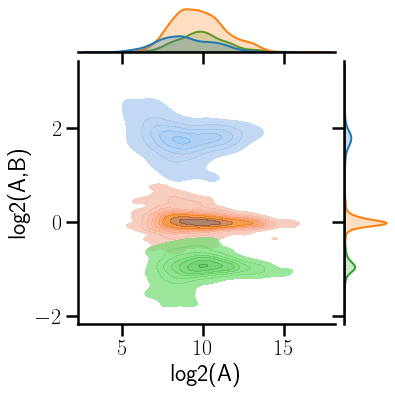

In [90]:
g = sns.jointplot(data = df_final, x = "log2(A)", y = "log2(A,B)", hue = "specie", kind = "kde", height = 6, 
             fill = True,  joint_kws={'alpha': 0.7})#, line_kws = {"ls":"--"}, label ="ECOLI")

g.ax_joint.legend().set_visible(False)
#sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")

In [91]:
df_triq["log2(mu_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].mean(axis = 1))
df_triq["log2(mu_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].mean(axis = 1))
df_triq["log2(median_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].median(axis = 1))
df_triq["log2(median_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].median(axis = 1))
df_triq["log2(mu_sample1-mu_sample2)"] = (df_triq["log2(mu_sample1)"] - df_triq["log2(mu_sample2)"])


In [92]:
df_triq["mu_sample1"] = np.exp(np.log(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]).mean(axis = 1))
df_triq["mu_sample2"] = np.exp(np.log(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]]).mean(axis = 1))
df_triq["log2FC"] = (df_triq["mu_sample1"] - df_triq["mu_sample2"])
df_triq["-log2_fold_change"] = -1* df_triq["log2_fold_change"]

In [93]:
### muProtein experiment

df_triq["mu_sample1"] = df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]


In [94]:
df_triq[df_triq.specie == "ECOLI"]["mu_sample1"] = -df_triq[df_triq.specie == "ECOLI"]["mu_sample1"]

/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
#def ecoli_sign_correction(x):
#    if x == "ECOLI":
#        return -1
#    else:
#        return 1

#df_triq["ecoli_correction_sign"] = df_triq.specie.map(ecoli_sign_correction)


In [96]:
#df_triq.mu_sample1 = df_triq["ecoli_correction_sign"] * df_triq.mu_sample1

In [97]:
muProtein = -0.003126
df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]]

,1:002-Pedro,1:004-Pedro,1:006-Pedro
0,0.4654,0.4414,0.5506
482,0.6198,0.7536,0.3832
483,0.5318,0.6788,0.6745
485,0.4948,0.6326,0.6983
486,0.5543,0.7717,0.5079
...,...,...,...
1099,1.2050,1.3310,1.3330
1098,1.2500,1.2890,1.3400
1097,1.2590,1.3230,1.4010
1108,1.2490,1.3230,1.4050


In [98]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.set_ylim([-4, 4])
ax.set_xlim([-5, 5])

(-5.0, 5.0)

RuntimeError: latex was not able to process the following string:
b'mu_sample1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ptruong/.cache/matplotlib/tex.cache/ae99e02dfd50786cfa6915464b17e467.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./ae99e02dfd50786cfa6915464b17e467.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily mu_
                   sample1}
No pages of output.
Transcript written on ae99e02dfd50786cfa6915464b17e467.log.




<Figure size 1080x576 with 1 Axes>

In [99]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", height = 10, 
              xlim = (0,5), ylim = (-5,5))

RuntimeError: latex was not able to process the following string:
b'mu_sample1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ptruong/.cache/matplotlib/tex.cache/ae99e02dfd50786cfa6915464b17e467.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./ae99e02dfd50786cfa6915464b17e467.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily mu_
                   sample1}
No pages of output.
Transcript written on ae99e02dfd50786cfa6915464b17e467.log.




RuntimeError: latex was not able to process the following string:
b'mu_sample1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ptruong/.cache/matplotlib/tex.cache/ae99e02dfd50786cfa6915464b17e467.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./ae99e02dfd50786cfa6915464b17e467.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily mu_
                   sample1}
No pages of output.
Transcript written on ae99e02dfd50786cfa6915464b17e467.log.




<Figure size 720x720 with 3 Axes>

In [ ]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", kind = "kde", height = 10, 
              xlim = (0,5), ylim = (-5,5),
             fill = True, joint_kws={'alpha': 0.4})

In [ ]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")
msrob_protein = pd.read_csv("msqrobsum_protein_sum_20210817.csv", sep = "\t")
msstat_protein = pd.read_csv("msstat_output_runleveldata.csv", sep = ",")
msstat_run = pd.read_csv("msstats_run.csv", sep = ",")

In [ ]:
msrob_protein["sample"].unique()

In [ ]:
msstat_protein.RUN.unique()

In [ ]:
run_to_replicate_mapper = dict(msstat_run[["Run","BioReplicate"]].values)
run_to_condition_mapper = dict(msstat_run[["Run", "Condition"]].values)
msstat_protein["replicate"] = msstat_protein.RUN.map(run_to_replicate_mapper)
msstat_protein["condition"] = msstat_protein.RUN.map(run_to_condition_mapper)
msrob_protein_sum = msrob_protein.groupby(["proteins", "condition"]).mean()
msrob_sample1 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 1].expression.droplevel("condition")
msrob_sample2 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 2].expression.droplevel("condition")

#msrob_log2 = np.log2(msrob_sample1) - np.log2(msrob_sample2)
#msrob_log2 = np.log2(msrob_sample2) - np.log2(msrob_sample1)
msrob_log2 = msrob_sample2 - msrob_sample1

In [ ]:
msrob_sample1.name = "sample1"
msrob_sample2.name = "sample2"
msrob_log2.name = "log2FC"
msrob_df = pd.concat([msrob_sample1, msrob_sample2, msrob_log2], axis = 1)
species_mapper = lambda x: x.split("_")[-1]
msrob_df["specie"] = msrob_df.index.map(species_mapper)


In [ ]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

In [ ]:
g = sns.jointplot(data = msrob_df, x = "sample1", y = "log2FC", hue = "specie", height = 6)#, 
#              xlim = (0,5), ylim = (-5,5))
g.ax_joint.legend().set_visible(False)

In [ ]:
g = sns.jointplot(data = msrob_df, x = "sample1", y = "log2FC", hue = "specie", height = 6, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.7})
g.ax_joint.legend().set_visible(False)

In [ ]:
msstat_sum = msstat_protein.groupby(["Protein", "GROUP_ORIGINAL"]).LogIntensities.mean()


In [ ]:
msstat_sum_sample1 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 1].droplevel("GROUP_ORIGINAL")
msstat_sum_sample2 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 2].droplevel("GROUP_ORIGINAL")
msstat_log2 = msstat_sum_sample2 - msstat_sum_sample1

msstat_sum_sample1.name = "sample1"
msstat_sum_sample2.name = "sample2"
msstat_log2.name = "log2FC"

In [ ]:
msstat_df = pd.concat([msstat_sum_sample1, msstat_sum_sample2, msstat_log2], axis = 1)
msstat_df["specie"] = msstat_df.index.map(specie_mapper)

In [ ]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

In [ ]:
g = sns.jointplot(data = msstat_df, x = "sample1", y = "log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))


In [ ]:
g = sns.jointplot(data = msstat_df, x = "sample1", y = "log2FC", hue = "specie", height = 6, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.7})
g.ax_joint.legend().set_visible(False)

# OSW scatter


In [ ]:
sns.jointplot(data = df_final_osw, x = "log2(A)", y = "log2(A,B)", hue = "specie", kind = "kde", height = 10, 
             fill = True,  joint_kws={'alpha': 0.7})#, line_kws = {"ls":"--"}, label ="ECOLI")

In [ ]:
sns.jointplot(data = msrob_df, x = "sample1", y = "log2FC", hue = "specie", height = 10, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.7})

In [ ]:
sns.jointplot(data = msstat_df, x = "sample1", y = "log2FC", hue = "specie", height = 10, kind = "kde", 
              fill = True, joint_kws={'alpha': 0.7})

In [ ]:
df_triq["mu_sample1"]

In [ ]:
df_triq["-mu_sample1"] = np.log(df_triq["mu_sample1"]).abs()
df_triq["-mu_sample1"]

df_triq["-mu_sample2"] = np.log(df_triq["mu_sample2"]).abs()
df_triq["-mu_sample2"]

In [ ]:

f, ax = plt.subplots(2, 2, figsize = (15,8))

df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "YEAST")
ax[0,0].legend()
ax[0,0].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,0].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,0].set_title("Top3")

sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[0,1].legend()
ax[0,1].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,1].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,1].set_ylim([-4, 4])
ax[0,1].set_xlim([0, 3.5])
ax[0,1].set_title("triqler")

sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,0].legend()
ax[1,0].axhline(2, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,0].axhline(-1, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,0].set_title("msqrobsum")

sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,1].legend()
ax[1,1].axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,1].axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,1].set_title("MSstats")

plt.suptitle("DIANN protein level results")

## Scaled  calibration plots 

In [ ]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    ecoli_scaling_factor = []
    yeast_scaling_factor = []
    human_scaling_factor = []
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        ecoli_factor = (df_triq["specie"] == "ECOLI").sum()/(df_triq["specie"] == "HUMAN").sum()
        yeast_factor = (df_triq["specie"] == "YEAST").sum()/(df_triq["specie"] == "HUMAN").sum()
        human_factor = (df_triq["specie"] == "HUMAN").sum()/(df_triq["specie"] == "HUMAN").sum()
        df_triq = df_triq[df_triq.q_value < q_val]
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        ecoli_scaling_factor.append(ecoli_factor) #Should be same for all values because we want the full length of protein list
        yeast_scaling_factor.append(yeast_factor) #Should be same for all values because we want the full length of protein list
        human_scaling_factor.append(human_factor)
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec,
                               human_scaling_factor, yeast_scaling_factor, ecoli_scaling_factor]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI", "HUMAN_factor", "YEAS8_factor", "ECOLI_factor"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            #print(df)
            try:
                val = list(df[df.index == fc].values[0])
            except:
                print(df)
                break
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI", "HUMAN_factor", "YEAST_factor", "ECOLI_factor"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)


In [ ]:
def get_top3_factor(specie):
    return len(df_final[df_final.index.get_level_values("specie") == specie])/len(df_final[df_final.index.get_level_values("specie") == "HUMAN"])

#triqler_factor() # contained in res from get_DE_for_fcs - triqler read-in funciton

def get_msstat_factor(specie):
    return len(ms[ms["specie"] == specie]) / len(ms[ms["specie"] == "HUMAN"])  

def get_msqrob_factor(specie):
    return len(msqrob[msqrob["specie"] == specie]) / len(msqrob[msqrob["specie"] == "HUMAN"])

In [ ]:
res = get_DE_for_fcs( fcs = [fc])

In [ ]:
#row = 0
#col = 0
#specie = "ECOLI"
#fcs = fcs
#fcs.sort()
#for i in range(20):
#    fc = fcs[i]

def scaled_FP_DE_plot(axs, col, fc, specie):
    top3_factor = get_top3_factor(specie)
    msstat_factor = get_msstat_factor(specie)
    msqrob_factor = get_msqrob_factor(specie)

    
    if specie == "all":
        top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAST")
        msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAST")
        msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAST")


        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))) * (top3_factor)
        df_triq = ((res[0]["HUMAN"] / 
                   res[0].sum(axis=1))) * (res[0]["HUMAN_factor"]+res[0]["ECOLI_factor"] +res[0]["YEAST_factor"] )
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))) * msqrob_factor        
    else:
        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))) * top3_factor
        df_triq = ((res[0]["HUMAN"] / 
                   res[0][specie])) * res[0][specie + "_factor"]
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))) * msqrob_factor   

    df_triq.plot(ax = axs[col], style = "b") # triqler data plot
    axs[col].plot(df.index, df.DE, "m") # plot osw top3
    axs[col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
    axs[col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

    axs[col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    #axs[row, col].set_title(f"fc = {fc}")
    #axs[row, col].set_xlabel("q-value")
    #axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")

    def abline(slope, intercept, col):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs[col].get_xlim())
        y_vals = intercept + slope * x_vals
        axs[col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0,col)
    #col+=1
    #if col == 5:
    #    row+=1
    #    col=0
    #plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    #plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
#scaled_FP_DE_plot(axs, col = 0, fc = 0.4, specie = "HUMAN")
#axs[0,0].set_title("HUMAN")
scaled_FP_DE_plot(axs, col = 0, fc = 0.4, specie = "YEAST")
axs[0].set_title("YEAST")
scaled_FP_DE_plot(axs, col = 1, fc = 0.4, specie = "ECOLI")
axs[1].set_title("ECOLI")
scaled_FP_DE_plot(axs, col = 2, fc = 0.4, specie = "all")
axs[2].set_title("all")
plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)


In [ ]:
res_ = get_DE_for_fcs( fcs = [0.4])

In [ ]:
specie

# Volcano

In [ ]:

df_final

In [ ]:
from bioinfokit import analys, visuz

# Top3 

In [ ]:
#fig, axs = plt.subplots(2, 2, figsize=(20,6))
#df_final["-log10(q)"] = -np.log10(df_final.q)
#sns.scatterplot(data = df_final, x = "log2(A,B)", y = "-log10(q)", ax = axs[0,0])
visuz.gene_exp.volcano(df= df_final, lfc = "log2(A,B)", pv="q", show = True, dim = (10, 10), lfc_thr=(0.5, 1) )

# Triqler

In [ ]:
visuz.gene_exp.volcano(df= df_triq, lfc = "log2FC", pv="q_value", show = True, dim = (10, 10), lfc_thr=(0.5, 1))


In [ ]:
visuz.gene_exp.volcano(df= df_triq, lfc = "log2FC", pv="q_value", show = True, dim = (10, 10), xlm=[-5, 5, 1], lfc_thr=(0.5, 1))


# MSqRobSum

In [ ]:
visuz.gene_exp.volcano(df= msqrob, lfc = "logFC", pv="qvalue", show = True, dim = (10, 10), lfc_thr=(1, 0.5))

# MsStat

In [ ]:
visuz.gene_exp.volcano(df= ms[~ms["adj.pvalue"].isna()], lfc = "log2FC", pv="adj.pvalue", show = True, dim = (10, 10), lfc_thr=(1, 0.5))

In [ ]:
help(visuz.gene_exp.volcano)

# Triqler absoluute protein quantifications

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.set_ylim([-4, 4])
ax.set_xlim([-5, 5])

In [ ]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/py37_triqler_mod_test_20210831")

q_val = 1
file = "fc_1.00"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val] # not filtered by q_value
df_triq["specie"] = df_triq.protein.map(specie_mapper)
df_triq.sort_values(by = "specie", inplace = True)
df_triq.log2_fold_change = -df_triq.log2_fold_change


In [ ]:
tmp = pd.read_csv("triqler_input_diann_searchScore_Qvalue.csv", sep = "\t")

In [ ]:
tmp

In [ ]:
df_triq_absolute_quantity = pd.read_csv("geoAvgQuantRow.csv", sep = "\t")

In [ ]:
df_triq_absolute_quantity

In [ ]:
df_triq

In [ ]:
#bool(set(df_triq.protein) & set(df_triq_absolute_quantity.Protein))
len(set(df_triq.protein).intersection( set(df_triq_absolute_quantity.protein)))

In [ ]:
#df_triq_absolute_quantity[df_triq_absolute_quantity.Protein == "P53337_YEAST"]

In [ ]:
df_triq[df_triq.protein == "P53337_YEAST"]

In [ ]:
df_triq.set_index("protein", inplace = True)

In [ ]:
df_triq_absolute_quantity.set_index("protein", inplace = True)

In [ ]:
df_triq = pd.concat([df_triq, df_triq_absolute_quantity], axis = 1)

In [ ]:
df_triq

In [ ]:
prefix = "nonNorm_"
#prefix = "geomAvg_"
df_triq["log2(mu_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].mean(axis = 1))
df_triq["log2(mu_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].mean(axis = 1))
df_triq["log2(median_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].median(axis = 1))
df_triq["log2(median_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].median(axis = 1))
df_triq["log2(max_sample1)"] = np.log2(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].max(axis = 1))
df_triq["log2(max_sample2)"] = np.log2(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].max(axis = 1))

df_triq["log2(mu_sample1-mu_sample2)"] = (df_triq["log2(mu_sample1)"] - df_triq["log2(mu_sample2)"])
df_triq["log2(median_sample1-median_sample2)"] = (df_triq["log2(median_sample1)"] - df_triq["log2(median_sample2)"])
df_triq["log2(max_sample1-max_sample2)"] = (df_triq["log2(max_sample1)"] - df_triq["log2(max_sample2)"])



#df_triq["mu_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).mean(axis = 1))
#df_triq["mu_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).mean(axis = 1))
#df_triq["median_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).median(axis = 1))
#df_triq["median_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).median(axis = 1))
#df_triq["max_sample1"] = np.exp(np.log(df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]]).max(axis = 1))
#df_triq["max_sample2"] = np.exp(np.log(df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]]).max(axis = 1))
#df_triq["mu_log2FC"] = np.log(df_triq["mu_sample1"]) - np.log(df_triq["mu_sample2"])
#df_triq["median_log2FC"] = np.log(df_triq["median_sample1"]) - np.log(df_triq["median_sample2"])
#df_triq["max_log2FC"] = np.log(df_triq["max_sample1"]) - np.log(df_triq["max_sample2"])

df_triq["mu_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].mean(axis = 1)
df_triq["mu_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].mean(axis = 1)
df_triq["median_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].median(axis = 1)
df_triq["median_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].median(axis = 1)
df_triq["max_sample1"] = df_triq[[prefix + "1:002-Pedro", prefix + "1:004-Pedro", prefix + "1:006-Pedro"]].max(axis = 1)
df_triq["max_sample2"] = df_triq[[prefix + "2:003-Pedro", prefix + "2:005-Pedro", prefix + "2:007-Pedro"]].max(axis = 1)
df_triq["mu_log2FC"] = df_triq["mu_sample1"] - df_triq["mu_sample2"]
df_triq["median_log2FC"] = df_triq["median_sample1"] - df_triq["median_sample2"]
df_triq["max_log2FC"] = df_triq["max_sample1"] - df_triq["max_sample2"]



df_triq["-log2_fold_change"] = -1* df_triq["log2_fold_change"]

# Non-KDE style plot

# log2 quantities - triqler fc

In [ ]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (-5,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2_fold_change", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

# log2 quantities 

In [ ]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2(mu_sample1-mu_sample2)", hue = "specie", height = 10)#, 
              #xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2(median_sample1-median_sample2)", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2(max_sample1-max_sample2)", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# no log2  - triqler fc

In [ ]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "median_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "max_sample1", y = "log2_fold_change", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# no log2 

In [ ]:
sns.jointplot(data = df_triq, x = "mu_sample1", y = "mu_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "median_sample1", y = "median_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "max_sample1", y = "max_log2FC", hue = "specie", height = 10)#, 
#              xlim = (0,5), ylim = (-5,5))

# kde style plots

In [ ]:
g = sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2_fold_change", hue = "specie", height = 6, 
              kind = "kde", fill = True, joint_kws={'alpha': 0.7} )#, 
              #xlim = (-5,5), ylim = (-5,5))
g.ax_joint.legend().set_visible(False)

In [ ]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2_fold_change", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2_fold_change", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(mu_sample1)", y = "log2(mu_sample1-mu_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
              #xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(median_sample1)", y = "log2(median_sample1-median_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4}
             )#, 
#              xlim = (0,5), ylim = (-5,5))

In [ ]:
sns.jointplot(data = df_triq, x = "log2(max_sample1)", y = "log2(max_sample1-max_sample2)", hue = "specie", height = 10,
             kind = "kde", fill = True, joint_kws={'alpha': 0.4})#, 
#              xlim = (0,5), ylim = (-5,5))